# Create and Train the Deep Learning Model

In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, cohen_kappa_score
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold
from keras.layers.recurrent import GRU
from keras.models import Sequential, load_model
from keras.regularizers import l2
from keras.layers import Dense, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ModelCheckpoint, Callback
from keras import backend as K
from IPython.display import clear_output

Using TensorFlow backend.


### Load the Data

In [2]:
X_train = np.load('arrays/X_train.npy')
X_test = np.load('arrays/X_test.npy')
y_train = np.load('arrays/y_train.npy')
y_test = np.load('arrays/y_test.npy')

### Define the Model

In [3]:
num_classes = 2
token_length = 100
num_features = 16

def regularization_constructor(alpha):
    if alpha:
        return l2(alpha)
    else:
        return None

def create_model(dropout=0, recurrent_dropout=0, recurrent_num_hidden=50, num_hidden=200,
                 gru_activation='tanh', recurrent_activation='tanh', activation='relu',
                 rec_l2=0.01, ker_l2=None, bias_l2=None, act_l2=0.01, 
                 dense_ker_l2=0.01, dense_bias_l2=None, dense_act_l2=None, 
                 verbose=False):
    rec_l2 = regularization_constructor(rec_l2)
    ker_l2 = regularization_constructor(ker_l2)
    bias_l2 = regularization_constructor(bias_l2)
    act_l2 = regularization_constructor(act_l2)
    dense_ker_l2 = regularization_constructor(dense_ker_l2)
    dense_bias_l2 = regularization_constructor(dense_bias_l2)
    dense_act_l2 = regularization_constructor(dense_act_l2)
    
    model = Sequential()
    model.add(BatchNormalization(input_shape=(token_length, num_features,)))
    model.add(GRU(units=recurrent_num_hidden, return_sequences=False, recurrent_dropout=recurrent_dropout,
                        dropout=dropout, activation=gru_activation, recurrent_activation=recurrent_activation,
                        recurrent_regularizer=rec_l2,
                        kernel_regularizer=ker_l2,
                        bias_regularizer=bias_l2,
                        activity_regularizer=act_l2,
                        input_shape=(token_length, num_features,)))
    model.add(Dense(num_hidden, activation=activation,
                   kernel_regularizer=dense_ker_l2,
                   bias_regularizer=dense_bias_l2,
                   activity_regularizer=dense_act_l2))
    model.add(Dense(1, activation='sigmoid'))
    if verbose:
        print(model.summary())
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

### Define Training Callback Functions

In [4]:
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
train_plot = PlotLearning()

filepath="results/weights.best.mfcc.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)
fit_callbacks = [checkpoint, train_plot]

cross_val_filepath="results/cross-val-weights-{acc:.1f}.hdf5"
cross_checkpoint = ModelCheckpoint(cross_val_filepath, monitor='loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)
cross_callbacks = [cross_checkpoint]

### Train Hyperparameters

Define the Combinations

In [5]:
node_params = {
    'num_hidden': [50, 100, 200],
    'recurrent_num_hidden': [50, 100, 200]
}

activation_params = {
    'gru_activation': ['relu', 'tanh'],
    'activation': ['relu', 'tanh'],
    'recurrent_activation': ['relu', 'tanh']
}

dropout_params = {
    'dropout': [0, 0.1, 0.3],
    'recurrent_dropout': [0, 0.1, 0.3]
}

reg_params = {
    'dense_ker_l2': [None, 0.01],
    'dense_bias_l2': [None, 0.01],
    'dense_act_l2': [None, 0.01]
}

recurrent_reg_params = {
    'rec_l2': [None, 0.01],
    'ker_l2': [None, 0.01],
    'bias_l2': [None, 0.01],
    'act_l2': [None, 0.01]
}

num_splits = 3
num_epochs = 150

Fit Activation

In [6]:
best_params = dict()

In [7]:
model = KerasClassifier(build_fn=create_model, **best_params)
kfold = StratifiedKFold(n_splits=num_splits)
grid = GridSearchCV(model, activation_params, cv=kfold, error_score=0, verbose=0)
grid.fit(X_train, y_train, epochs=num_epochs)
print(grid.best_params_)
best_params.update(grid.best_params_)

Epoch 1/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0010
Epoch 2/150
1999/1999 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 3/150
1999/1999 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 4/150
1999/1999 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 5/150
1999/1999 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 6/150
1999/1999 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 7/150
1999/1999 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 8/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 9/150
1999/1999 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 10/150
1999/1999 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 11/150


1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 84/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 85/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 86/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 87/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 88/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 89/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 90/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 91/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 92/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 93/150


2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 96/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 97/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 98/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 99/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 100/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 101/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 102/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 103/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 104/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 10

Epoch 107/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 108/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 109/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 110/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 111/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 112/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 113/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 114/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 115/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 116/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0

1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 119/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 120/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 121/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 122/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 123/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 124/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 125/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 126/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 127/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoc

2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 130/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 131/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 132/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 133/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 134/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 135/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 136/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 137/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 138/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoc

2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 141/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 142/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 143/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 144/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 145/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 146/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 147/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 148/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 149/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoc

1999/1999 [==============================] - 1s 380us/step
Epoch 1/150
2000/2000 [==============================] - 6s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 2/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 3/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 4/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 5/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 6/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 7/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 8/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 9/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 10/150
2000/2000 [==========================

2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 83/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 84/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 85/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 86/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 87/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 88/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 89/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 90/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 91/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 92/150


2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 94/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 95/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 96/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 97/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 98/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 99/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 100/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 101/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 102/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 103/

1999/1999 [==============================] - 4s 2ms/step - loss: 0.6537 - acc: 0.6993
Epoch 106/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7742 - acc: 0.7049
Epoch 107/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7763 - acc: 0.6928
Epoch 108/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6522 - acc: 0.6933
Epoch 109/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6834 - acc: 0.6973
Epoch 110/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6746 - acc: 0.7149
Epoch 111/150
1999/1999 [==============================] - 4s 2ms/step - loss: 1.1219 - acc: 0.7044
Epoch 112/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7632 - acc: 0.7244
Epoch 113/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6464 - acc: 0.7014
Epoch 114/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7586 - acc: 0.7029
Epoch 115/150


2000/2000 [==============================] - 4s 2ms/step - loss: 0.6722 - acc: 0.6555
Epoch 119/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6611 - acc: 0.6610
Epoch 120/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6575 - acc: 0.6570
Epoch 121/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7961 - acc: 0.6575
Epoch 122/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6758 - acc: 0.6560
Epoch 123/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6927 - acc: 0.6615
Epoch 124/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6910 - acc: 0.6540
Epoch 125/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7206 - acc: 0.6520
Epoch 126/150
2000/2000 [==============================] - 4s 2ms/step - loss: 1.2252 - acc: 0.6590
Epoch 127/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6901 - acc: 0.6590
Epoch 128/150


2001/2001 [==============================] - 4s 2ms/step - loss: 0.9163 - acc: 0.6667
Epoch 132/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6518 - acc: 0.6712
Epoch 133/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7983 - acc: 0.6657
Epoch 134/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7563 - acc: 0.6677
Epoch 135/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6495 - acc: 0.6662
Epoch 136/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6381 - acc: 0.6767
Epoch 137/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6552 - acc: 0.6732
Epoch 138/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6841 - acc: 0.6617
Epoch 139/150
2001/2001 [==============================] - 4s 2ms/step - loss: 1.2948 - acc: 0.6672
Epoch 140/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6504 - acc: 0.6602
Epoch 141/150


1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 63/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 64/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 65/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 66/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 67/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 68/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 69/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 70/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 71/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 72/150


2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 74/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 75/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 76/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 77/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 78/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 79/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 80/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 81/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 82/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 83/150


2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 86/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 87/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 88/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 89/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 90/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 91/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 92/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 93/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 94/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 95/150


1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 97/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 98/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 99/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 100/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 101/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 102/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 103/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 104/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 105/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 1

Epoch 108/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 109/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 110/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 111/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 112/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 113/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 114/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 115/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 116/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 117/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0

2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 120/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 121/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 122/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 123/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 124/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 125/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 126/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 127/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 128/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoc

1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 131/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 132/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 133/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 134/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 135/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 136/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 137/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 138/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 139/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoc

2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 142/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 143/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 144/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 145/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 146/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 147/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 148/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 149/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00: 0s - loss: nan - a
Epoch 150/150
2000/2000 [==============================] - 1s 393us/step
Epoch 1/150


1999/1999 [==============================] - 7s 4ms/step - loss: 1.6777 - acc: 0.6213
Epoch 2/150
1999/1999 [==============================] - 4s 2ms/step - loss: 1.0917 - acc: 0.6573
Epoch 3/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.9184 - acc: 0.6643
Epoch 4/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.8364 - acc: 0.6658
Epoch 5/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.8874 - acc: 0.6713
Epoch 6/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7934 - acc: 0.6713
Epoch 7/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7723 - acc: 0.6733
Epoch 8/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7678 - acc: 0.6703
Epoch 9/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7606 - acc: 0.6713
Epoch 10/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7138 - acc: 0.6593
Epoch 11/150
1999/1999 [=======

Epoch 84/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6322 - acc: 0.6558
Epoch 85/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6272 - acc: 0.6728
Epoch 86/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6306 - acc: 0.6573
Epoch 87/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6284 - acc: 0.6698
Epoch 88/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6277 - acc: 0.6758
Epoch 89/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6602 - acc: 0.6568
Epoch 90/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6549 - acc: 0.6543
Epoch 91/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6416 - acc: 0.6673
Epoch 92/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6295 - acc: 0.6658
Epoch 93/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6401 - acc: 0.6563
Epoch 94/1

2000/2000 [==============================] - 4s 2ms/step - loss: 0.6378 - acc: 0.6520
Epoch 97/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6417 - acc: 0.6600
Epoch 98/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6386 - acc: 0.6595
Epoch 99/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6547 - acc: 0.6500
Epoch 100/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6447 - acc: 0.6535
Epoch 101/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6418 - acc: 0.6535
Epoch 102/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6464 - acc: 0.6635
Epoch 103/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6411 - acc: 0.6460
Epoch 104/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6492 - acc: 0.6490
Epoch 105/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6464 - acc: 0.6535
Epoch 106/150
200

2001/2001 [==============================] - 4s 2ms/step - loss: 0.6381 - acc: 0.6612
Epoch 110/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6353 - acc: 0.6552
Epoch 111/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6399 - acc: 0.6512
Epoch 112/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6387 - acc: 0.6542
Epoch 113/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6392 - acc: 0.6502
Epoch 114/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6396 - acc: 0.6597
Epoch 115/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6398 - acc: 0.6537
Epoch 116/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6446 - acc: 0.6497
Epoch 117/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6378 - acc: 0.6547
Epoch 118/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6346 - acc: 0.6637
Epoch 119/150


3000/3000 [==============================] - 6s 2ms/step - loss: 0.6634 - acc: 0.6660
Epoch 123/150
3000/3000 [==============================] - 6s 2ms/step - loss: 0.6496 - acc: 0.6670
Epoch 124/150
3000/3000 [==============================] - 6s 2ms/step - loss: 0.6514 - acc: 0.6733
Epoch 125/150
3000/3000 [==============================] - 6s 2ms/step - loss: 0.6452 - acc: 0.6673
Epoch 126/150
3000/3000 [==============================] - 7s 2ms/step - loss: 0.6696 - acc: 0.6683
Epoch 127/150
3000/3000 [==============================] - 6s 2ms/step - loss: 0.7038 - acc: 0.6707
Epoch 128/150
3000/3000 [==============================] - 6s 2ms/step - loss: 0.6678 - acc: 0.6697
Epoch 129/150
3000/3000 [==============================] - 6s 2ms/step - loss: 0.6658 - acc: 0.6600
Epoch 130/150
3000/3000 [==============================] - 6s 2ms/step - loss: 0.6724 - acc: 0.6623
Epoch 131/150
3000/3000 [==============================] - 6s 2ms/step - loss: 0.6750 - acc: 0.6647
Epoch 132/150


Fit Node Count

In [8]:
model = KerasClassifier(build_fn=create_model, **best_params)
kfold = StratifiedKFold(n_splits=num_splits)
grid = GridSearchCV(model, node_params, cv=kfold, error_score=0, verbose=0)
grid.fit(X_train, y_train, epochs=num_epochs)
print(grid.best_params_)
best_params.update(grid.best_params_)

Epoch 1/150
1999/1999 [==============================] - 8s 4ms/step - loss: 1.0078 - acc: 0.6448A: 2s - loss: 1
Epoch 2/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.9041 - acc: 0.6493
Epoch 3/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.8988 - acc: 0.6478
Epoch 4/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.8003 - acc: 0.6478
Epoch 5/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7961 - acc: 0.6478
Epoch 6/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7851 - acc: 0.6473
Epoch 7/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.8037 - acc: 0.6478
Epoch 8/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7615 - acc: 0.6478
Epoch 9/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7339 - acc: 0.6478
Epoch 10/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.8291 - acc: 0.6478
Epoc

2000/2000 [==============================] - 4s 2ms/step - loss: 0.6781 - acc: 0.6475
Epoch 15/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6648 - acc: 0.6475
Epoch 16/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6662 - acc: 0.6475
Epoch 17/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7116 - acc: 0.6470
Epoch 18/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6981 - acc: 0.6475
Epoch 19/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8024 - acc: 0.6475
Epoch 20/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6804 - acc: 0.6475
Epoch 21/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7021 - acc: 0.6470
Epoch 22/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6822 - acc: 0.6470
Epoch 23/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7375 - acc: 0.6480
Epoch 24/150
2000/2000 

Epoch 27/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6747 - acc: 0.6477
Epoch 28/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6667 - acc: 0.6477
Epoch 29/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7032 - acc: 0.6472
Epoch 30/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6831 - acc: 0.6477
Epoch 31/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6532 - acc: 0.6477
Epoch 32/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6591 - acc: 0.6477
Epoch 33/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7115 - acc: 0.6477
Epoch 34/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6952 - acc: 0.6477
Epoch 35/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7465 - acc: 0.6477
Epoch 36/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6816 - acc: 0.6477
Epoch 37/1

1999/1999 [==============================] - 4s 2ms/step - loss: 0.8808 - acc: 0.6573
Epoch 41/150
1999/1999 [==============================] - 4s 2ms/step - loss: 1.0423 - acc: 0.6613
Epoch 42/150
1999/1999 [==============================] - 4s 2ms/step - loss: 1.2212 - acc: 0.6593
Epoch 43/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.8614 - acc: 0.6523
Epoch 44/150
1999/1999 [==============================] - 4s 2ms/step - loss: 1.0696 - acc: 0.6548
Epoch 45/150
1999/1999 [==============================] - 4s 2ms/step - loss: 1.1089 - acc: 0.6593
Epoch 46/150
1999/1999 [==============================] - 4s 2ms/step - loss: 1.4419 - acc: 0.6568
Epoch 47/150
1999/1999 [==============================] - 4s 2ms/step - loss: 1.5706 - acc: 0.6563
Epoch 48/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.9768 - acc: 0.6563
Epoch 49/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.8974 - acc: 0.6558
Epoch 50/150
1999/1999 

2000/2000 [==============================] - 4s 2ms/step - loss: 0.7201 - acc: 0.6625
Epoch 54/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7479 - acc: 0.6620
Epoch 55/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8215 - acc: 0.6620
Epoch 56/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8333 - acc: 0.6550
Epoch 57/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7370 - acc: 0.6590
Epoch 58/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7271 - acc: 0.6635
Epoch 59/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.9095 - acc: 0.6605
Epoch 60/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.9339 - acc: 0.6545
Epoch 61/150
2000/2000 [==============================] - 4s 2ms/step - loss: 1.0276 - acc: 0.6595
Epoch 62/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.9813 - acc: 0.6625
Epoch 63/150
2000/2000 

2001/2001 [==============================] - 4s 2ms/step - loss: 0.6968 - acc: 0.6482
Epoch 67/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6535 - acc: 0.6477
Epoch 68/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.8191 - acc: 0.6492
Epoch 69/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7020 - acc: 0.6472
Epoch 70/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7574 - acc: 0.6477
Epoch 71/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6906 - acc: 0.6462
Epoch 72/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7460 - acc: 0.6477
Epoch 73/150
2001/2001 [==============================] - 4s 2ms/step - loss: 1.0398 - acc: 0.6477
Epoch 74/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7707 - acc: 0.6472
Epoch 75/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7883 - acc: 0.6482A: 0s - loss: 0.7561
Epo

Epoch 148/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7117 - acc: 0.6477
Epoch 149/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6862 - acc: 0.6472
Epoch 150/150
2001/2001 [==============================] - 1s 459us/step
Epoch 1/150
1999/1999 [==============================] - 9s 5ms/step - loss: 0.6966 - acc: 0.6523
Epoch 2/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.6745 - acc: 0.6468
Epoch 3/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.6749 - acc: 0.6478
Epoch 4/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.7285 - acc: 0.6473
Epoch 5/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.6570 - acc: 0.6478
Epoch 6/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.6877 - acc: 0.6473
Epoch 7/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.6551 - acc: 0.6478
Epoch 8/150
1999/1999 [==================

2000/2000 [==============================] - 5s 3ms/step - loss: 0.8284 - acc: 0.6460
Epoch 10/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.7658 - acc: 0.6495
Epoch 11/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.7386 - acc: 0.6470
Epoch 12/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.7373 - acc: 0.6485
Epoch 13/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.6974 - acc: 0.6475
Epoch 14/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.7512 - acc: 0.6470
Epoch 15/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.7917 - acc: 0.6455
Epoch 16/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.7418 - acc: 0.6470
Epoch 17/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.9123 - acc: 0.6485
Epoch 18/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.7584 - acc: 0.6480
Epoch 19/150
2000/2000 

2001/2001 [==============================] - 5s 3ms/step - loss: 0.8127 - acc: 0.6472
Epoch 22/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.8912 - acc: 0.6477
Epoch 23/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.9284 - acc: 0.6472
Epoch 24/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.8100 - acc: 0.6452
Epoch 25/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.8360 - acc: 0.6467
Epoch 26/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.7980 - acc: 0.6472
Epoch 27/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.8105 - acc: 0.6472
Epoch 28/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.8595 - acc: 0.6472
Epoch 29/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.7428 - acc: 0.6472
Epoch 30/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.7735 - acc: 0.6472
Epoch 31/150
2001/2001 

Epoch 34/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7470 - acc: 0.6638
Epoch 35/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7895 - acc: 0.6548
Epoch 36/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.9196 - acc: 0.6618
Epoch 37/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.8121 - acc: 0.6703
Epoch 38/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7794 - acc: 0.6608
Epoch 39/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.8430 - acc: 0.6708
Epoch 40/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7583 - acc: 0.6643
Epoch 41/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7701 - acc: 0.6658A
Epoch 42/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7833 - acc: 0.6688
Epoch 43/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7971 - acc: 0.6818
Epoch 44/

2000/2000 [==============================] - 4s 2ms/step - loss: 0.6483 - acc: 0.6475
Epoch 48/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6996 - acc: 0.6480
Epoch 49/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6890 - acc: 0.6470
Epoch 50/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6934 - acc: 0.6475
Epoch 51/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8020 - acc: 0.6470
Epoch 52/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6964 - acc: 0.6485
Epoch 53/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6897 - acc: 0.6475
Epoch 54/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6634 - acc: 0.6475
Epoch 55/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6645 - acc: 0.6480
Epoch 56/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6675 - acc: 0.6475
Epoch 57/150
2000/2000 

2001/2001 [==============================] - 4s 2ms/step - loss: 0.6912 - acc: 0.7001
Epoch 61/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6280 - acc: 0.6952
Epoch 62/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5979 - acc: 0.6962
Epoch 63/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6022 - acc: 0.6832
Epoch 64/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6823 - acc: 0.6882
Epoch 65/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7513 - acc: 0.6937
Epoch 66/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6683 - acc: 0.6817
Epoch 67/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6332 - acc: 0.6942
Epoch 68/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6570 - acc: 0.6907
Epoch 69/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6369 - acc: 0.6932
Epoch 70/150
2001/2001 

1999/1999 [==============================] - 4s 2ms/step - loss: 0.7208 - acc: 0.6853
Epoch 74/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6829 - acc: 0.6678
Epoch 75/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7784 - acc: 0.6748
Epoch 76/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6805 - acc: 0.6798
Epoch 77/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7685 - acc: 0.6818
Epoch 78/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7067 - acc: 0.6703
Epoch 79/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6884 - acc: 0.6758
Epoch 80/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6888 - acc: 0.6778
Epoch 81/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.8330 - acc: 0.6888
Epoch 82/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6835 - acc: 0.6798
Epoch 83/150
1999/1999 

2000/2000 [==============================] - 4s 2ms/step - loss: 0.6959 - acc: 0.6525
Epoch 86/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6796 - acc: 0.6470
Epoch 87/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6828 - acc: 0.6515
Epoch 88/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6770 - acc: 0.6540
Epoch 89/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7011 - acc: 0.6490
Epoch 90/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6903 - acc: 0.6530
Epoch 91/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7561 - acc: 0.6565
Epoch 92/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6778 - acc: 0.6485
Epoch 93/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6987 - acc: 0.6600
Epoch 94/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6593 - acc: 0.6575
Epoch 95/150
2000/2000 

2001/2001 [==============================] - 4s 2ms/step - loss: 0.6859 - acc: 0.6472
Epoch 17/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.8269 - acc: 0.6472
Epoch 18/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7130 - acc: 0.6477A: 1
Epoch 19/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7996 - acc: 0.6487
Epoch 20/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.9057 - acc: 0.6477
Epoch 21/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.9163 - acc: 0.6467
Epoch 22/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.8435 - acc: 0.6477
Epoch 23/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7693 - acc: 0.6462
Epoch 24/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.8185 - acc: 0.6472
Epoch 25/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.8131 - acc: 0.6492
Epoch 26/150
2001/2

1999/1999 [==============================] - 5s 3ms/step - loss: 0.9003 - acc: 0.6683
Epoch 30/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.9579 - acc: 0.6693
Epoch 31/150
1999/1999 [==============================] - 5s 3ms/step - loss: 1.0461 - acc: 0.6643
Epoch 32/150
1999/1999 [==============================] - 5s 3ms/step - loss: 1.1815 - acc: 0.6598
Epoch 33/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.8973 - acc: 0.6688
Epoch 34/150
1999/1999 [==============================] - 5s 3ms/step - loss: 1.2615 - acc: 0.6628
Epoch 35/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.8595 - acc: 0.6823
Epoch 36/150
1999/1999 [==============================] - 5s 2ms/step - loss: 0.8769 - acc: 0.6793
Epoch 37/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.9794 - acc: 0.6758
Epoch 38/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.8938 - acc: 0.6688
Epoch 39/150
1999/1999 

Epoch 42/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.7981 - acc: 0.6465
Epoch 43/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.9096 - acc: 0.6465
Epoch 44/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.7926 - acc: 0.6485
Epoch 45/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.7671 - acc: 0.6480
Epoch 46/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.8615 - acc: 0.6485
Epoch 47/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.9909 - acc: 0.6480
Epoch 48/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.7339 - acc: 0.6475
Epoch 49/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.9322 - acc: 0.6455
Epoch 50/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.8079 - acc: 0.6475
Epoch 51/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.7977 - acc: 0.6475
Epoch 52/1

2001/2001 [==============================] - 5s 3ms/step - loss: 1.0226 - acc: 0.6497
Epoch 55/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.8686 - acc: 0.6462
Epoch 56/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.8177 - acc: 0.6472
Epoch 57/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.8560 - acc: 0.6462
Epoch 58/150
2001/2001 [==============================] - 5s 3ms/step - loss: 1.3868 - acc: 0.6472
Epoch 59/150
2001/2001 [==============================] - 5s 3ms/step - loss: 1.3681 - acc: 0.6477
Epoch 60/150
2001/2001 [==============================] - 5s 3ms/step - loss: 1.0884 - acc: 0.6467
Epoch 61/150
2001/2001 [==============================] - 5s 3ms/step - loss: 1.1127 - acc: 0.6457
Epoch 62/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.9064 - acc: 0.6487
Epoch 63/150
2001/2001 [==============================] - 5s 3ms/step - loss: 1.7222 - acc: 0.6457
Epoch 64/150
2001/2001 

Epoch 136/150
2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 137/150
2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 138/150
2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 139/150
2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 140/150
2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 141/150
2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 142/150
2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 143/150
2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 144/150
2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 145/150
2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0

1999/1999 [==============================] - 4s 2ms/step - loss: 0.7288 - acc: 0.6788
Epoch 68/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.8085 - acc: 0.6893
Epoch 69/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6511 - acc: 0.6833
Epoch 70/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6878 - acc: 0.6903
Epoch 71/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7054 - acc: 0.6798
Epoch 72/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7064 - acc: 0.6883
Epoch 73/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6386 - acc: 0.6768
Epoch 74/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6481 - acc: 0.6863
Epoch 75/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6609 - acc: 0.6763
Epoch 76/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6826 - acc: 0.6798
Epoch 77/150
1999/1999 

2000/2000 [==============================] - 4s 2ms/step - loss: 0.5947 - acc: 0.6880
Epoch 81/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6094 - acc: 0.6890
Epoch 82/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6160 - acc: 0.6895
Epoch 83/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8215 - acc: 0.7005
Epoch 84/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6380 - acc: 0.6930
Epoch 85/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6476 - acc: 0.6925
Epoch 86/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7612 - acc: 0.6885
Epoch 87/150
2000/2000 [==============================] - 4s 2ms/step - loss: 1.0284 - acc: 0.6915
Epoch 88/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7313 - acc: 0.7065
Epoch 89/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8057 - acc: 0.6870
Epoch 90/150
2000/2000 

2001/2001 [==============================] - 4s 2ms/step - loss: 0.7010 - acc: 0.6637
Epoch 94/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7494 - acc: 0.6662
Epoch 95/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7268 - acc: 0.6587
Epoch 96/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6924 - acc: 0.6767
Epoch 97/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7004 - acc: 0.6632
Epoch 98/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7215 - acc: 0.6602
Epoch 99/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6863 - acc: 0.6612A: 1s
Epoch 100/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7569 - acc: 0.6652
Epoch 101/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6503 - acc: 0.6597
Epoch 102/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6849 - acc: 0.6687
Epoch 103/150
2

1999/1999 [==============================] - 4s 2ms/step - loss: 0.7362 - acc: 0.6928
Epoch 107/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6795 - acc: 0.6758
Epoch 108/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.8167 - acc: 0.6813
Epoch 109/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.9707 - acc: 0.6763
Epoch 110/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7270 - acc: 0.6773
Epoch 111/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.8202 - acc: 0.6823
Epoch 112/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7535 - acc: 0.6698
Epoch 113/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.9491 - acc: 0.6823
Epoch 114/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.8323 - acc: 0.6778
Epoch 115/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.8091 - acc: 0.6723
Epoch 116/150


2000/2000 [==============================] - 4s 2ms/step - loss: 1.0289 - acc: 0.6475
Epoch 38/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8327 - acc: 0.6450
Epoch 39/150
2000/2000 [==============================] - 4s 2ms/step - loss: 1.0130 - acc: 0.6480
Epoch 40/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8340 - acc: 0.6480
Epoch 41/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7391 - acc: 0.6470
Epoch 42/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.9002 - acc: 0.6490
Epoch 43/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8554 - acc: 0.6490
Epoch 44/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8276 - acc: 0.6475
Epoch 45/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.7387 - acc: 0.6470
Epoch 46/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6918 - acc: 0.6465
Epoch 47/150
2000/2000 

2001/2001 [==============================] - 4s 2ms/step - loss: 0.6973 - acc: 0.6472
Epoch 51/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.9636 - acc: 0.6477
Epoch 52/150
2001/2001 [==============================] - 4s 2ms/step - loss: 1.0629 - acc: 0.6472
Epoch 53/150
2001/2001 [==============================] - 4s 2ms/step - loss: 1.4191 - acc: 0.6467
Epoch 54/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.8692 - acc: 0.6482
Epoch 55/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.8549 - acc: 0.6467
Epoch 56/150
2001/2001 [==============================] - 4s 2ms/step - loss: 1.3266 - acc: 0.6482
Epoch 57/150
2001/2001 [==============================] - 4s 2ms/step - loss: 1.9829 - acc: 0.6467
Epoch 58/150
2001/2001 [==============================] - 4s 2ms/step - loss: 1.5248 - acc: 0.6487
Epoch 59/150
2001/2001 [==============================] - 4s 2ms/step - loss: 1.1179 - acc: 0.6472A: 0s - loss: 1.1695 - a

1999/1999 [==============================] - 5s 3ms/step - loss: 2.0926 - acc: 0.6668
Epoch 64/150
1999/1999 [==============================] - 5s 3ms/step - loss: 2.0859 - acc: 0.6683
Epoch 65/150
1999/1999 [==============================] - 5s 3ms/step - loss: 1.0856 - acc: 0.6648
Epoch 66/150
1999/1999 [==============================] - 5s 3ms/step - loss: 1.0831 - acc: 0.6718
Epoch 67/150
1999/1999 [==============================] - 5s 3ms/step - loss: 1.6221 - acc: 0.6703
Epoch 68/150
1999/1999 [==============================] - 5s 3ms/step - loss: 1.1926 - acc: 0.6618
Epoch 69/150
1999/1999 [==============================] - 6s 3ms/step - loss: 0.7828 - acc: 0.6713
Epoch 70/150
1999/1999 [==============================] - 5s 3ms/step - loss: 1.0961 - acc: 0.6688
Epoch 71/150
1999/1999 [==============================] - 5s 3ms/step - loss: 1.2335 - acc: 0.6658
Epoch 72/150
1999/1999 [==============================] - 5s 3ms/step - loss: 1.1485 - acc: 0.6698
Epoch 73/150
1999/1999 

2000/2000 [==============================] - 5s 3ms/step - loss: 1.0662 - acc: 0.6475
Epoch 76/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.9449 - acc: 0.6485
Epoch 77/150
2000/2000 [==============================] - 5s 3ms/step - loss: 1.2060 - acc: 0.6490
Epoch 78/150
2000/2000 [==============================] - 5s 3ms/step - loss: 1.2410 - acc: 0.6460
Epoch 79/150
2000/2000 [==============================] - 5s 3ms/step - loss: 1.1297 - acc: 0.6490
Epoch 80/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.9793 - acc: 0.6455
Epoch 81/150
2000/2000 [==============================] - 5s 3ms/step - loss: 1.3361 - acc: 0.6470
Epoch 82/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.9282 - acc: 0.6485
Epoch 83/150
2000/2000 [==============================] - 5s 3ms/step - loss: 1.5383 - acc: 0.6475
Epoch 84/150
2000/2000 [==============================] - 5s 3ms/step - loss: 1.0607 - acc: 0.6475
Epoch 85/150
2000/2000 

2001/2001 [==============================] - 5s 3ms/step - loss: 0.9963 - acc: 0.6497
Epoch 88/150
2001/2001 [==============================] - 5s 3ms/step - loss: 1.5462 - acc: 0.6482
Epoch 89/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.8220 - acc: 0.6472
Epoch 90/150
2001/2001 [==============================] - 5s 3ms/step - loss: 1.2838 - acc: 0.6467
Epoch 91/150
2001/2001 [==============================] - 5s 3ms/step - loss: 1.3466 - acc: 0.6452
Epoch 92/150
2001/2001 [==============================] - 5s 3ms/step - loss: 1.1693 - acc: 0.6472
Epoch 93/150
2001/2001 [==============================] - 5s 3ms/step - loss: 1.0592 - acc: 0.6462
Epoch 94/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.8684 - acc: 0.6467
Epoch 95/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.9178 - acc: 0.6467
Epoch 96/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.9203 - acc: 0.6482
Epoch 97/150
2001/2001 

3000/3000 [==============================] - 6s 2ms/step - loss: 0.6376 - acc: 0.6663
Epoch 100/150
3000/3000 [==============================] - 6s 2ms/step - loss: 0.6410 - acc: 0.6690
Epoch 101/150
3000/3000 [==============================] - 7s 2ms/step - loss: 0.6390 - acc: 0.6697
Epoch 102/150
3000/3000 [==============================] - 6s 2ms/step - loss: 0.6482 - acc: 0.6713
Epoch 103/150
3000/3000 [==============================] - 6s 2ms/step - loss: 0.6463 - acc: 0.6737
Epoch 104/150
3000/3000 [==============================] - 6s 2ms/step - loss: 0.6593 - acc: 0.6643
Epoch 105/150
3000/3000 [==============================] - 6s 2ms/step - loss: 0.6900 - acc: 0.6707
Epoch 106/150
3000/3000 [==============================] - 7s 2ms/step - loss: 0.6488 - acc: 0.6677
Epoch 107/150
3000/3000 [==============================] - 6s 2ms/step - loss: 0.6488 - acc: 0.6650
Epoch 108/150
3000/3000 [==============================] - 7s 2ms/step - loss: 0.6539 - acc: 0.6707
Epoch 109/150


Fit Dropout

In [9]:
model = KerasClassifier(build_fn=create_model, **best_params)
kfold = StratifiedKFold(n_splits=num_splits)
grid = GridSearchCV(model, dropout_params, cv=kfold, error_score=0, verbose=0)
grid.fit(X_train, y_train, epochs=num_epochs)
print(grid.best_params_)
best_params.update(grid.best_params_)

Epoch 1/150
1999/1999 [==============================] - 9s 5ms/step - loss: 0.7685 - acc: 0.6528
Epoch 2/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6737 - acc: 0.6478
Epoch 3/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6512 - acc: 0.6478
Epoch 4/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6374 - acc: 0.6483
Epoch 5/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6598 - acc: 0.6508
Epoch 6/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6350 - acc: 0.6563
Epoch 7/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6193 - acc: 0.6693
Epoch 8/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6206 - acc: 0.6763
Epoch 9/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.7908 - acc: 0.6753
Epoch 10/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.7898 - acc: 0.6898
Epoch 11/150
1999/1

2000/2000 [==============================] - 3s 2ms/step - loss: 0.7190 - acc: 0.6975
Epoch 14/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6169 - acc: 0.7050
Epoch 15/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5944 - acc: 0.6965
Epoch 16/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.7035 - acc: 0.7020
Epoch 17/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.7876 - acc: 0.7070
Epoch 18/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6355 - acc: 0.7120
Epoch 19/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5883 - acc: 0.7055A: 1s -
Epoch 20/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5628 - acc: 0.7205
Epoch 21/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5713 - acc: 0.7070
Epoch 22/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5766 - acc: 0.7225
Epoch 23/150
200

2001/2001 [==============================] - 3s 2ms/step - loss: 0.7398 - acc: 0.7151
Epoch 27/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.7936 - acc: 0.7171
Epoch 28/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6543 - acc: 0.7251
Epoch 29/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5935 - acc: 0.7206
Epoch 30/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5760 - acc: 0.7216
Epoch 31/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5677 - acc: 0.7246
Epoch 32/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5864 - acc: 0.7196
Epoch 33/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6697 - acc: 0.7181
Epoch 34/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5603 - acc: 0.7311
Epoch 35/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5755 - acc: 0.7206
Epoch 36/150
2001/2001 

1999/1999 [==============================] - 4s 2ms/step - loss: 0.5735 - acc: 0.7384
Epoch 40/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6114 - acc: 0.7319
Epoch 41/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5685 - acc: 0.7359
Epoch 42/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6565 - acc: 0.7479
Epoch 43/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5871 - acc: 0.7319
Epoch 44/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5823 - acc: 0.7349
Epoch 45/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6149 - acc: 0.7444
Epoch 46/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6659 - acc: 0.7414
Epoch 47/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6135 - acc: 0.7399
Epoch 48/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.8630 - acc: 0.7469
Epoch 49/150
1999/1999 

2000/2000 [==============================] - 3s 1ms/step - loss: 0.6021 - acc: 0.6935
Epoch 53/150
2000/2000 [==============================] - 3s 1ms/step - loss: 0.6846 - acc: 0.6885
Epoch 54/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6663 - acc: 0.6880
Epoch 55/150
2000/2000 [==============================] - 3s 1ms/step - loss: 0.8309 - acc: 0.6895
Epoch 56/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7372 - acc: 0.6895
Epoch 57/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7129 - acc: 0.6900
Epoch 58/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7338 - acc: 0.6900
Epoch 59/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7339 - acc: 0.6990
Epoch 60/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7156 - acc: 0.6935
Epoch 61/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6719 - acc: 0.6865
Epoch 62/150
2000/2000 

2001/2001 [==============================] - 4s 2ms/step - loss: 0.6383 - acc: 0.7146
Epoch 66/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6422 - acc: 0.7111
Epoch 67/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6317 - acc: 0.7161
Epoch 68/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6197 - acc: 0.7176
Epoch 69/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5962 - acc: 0.7106
Epoch 70/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5938 - acc: 0.7256
Epoch 71/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5893 - acc: 0.7281
Epoch 72/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5936 - acc: 0.7181
Epoch 73/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6434 - acc: 0.7181
Epoch 74/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6232 - acc: 0.7196
Epoch 75/150
2001/2001 

1999/1999 [==============================] - 4s 2ms/step - loss: 0.6141 - acc: 0.7574
Epoch 79/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6026 - acc: 0.7469
Epoch 80/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6828 - acc: 0.7579
Epoch 81/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5983 - acc: 0.7569
Epoch 82/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7648 - acc: 0.7554
Epoch 83/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5887 - acc: 0.7554
Epoch 84/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.8265 - acc: 0.7479
Epoch 85/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6886 - acc: 0.7539
Epoch 86/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5924 - acc: 0.7494
Epoch 87/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7431 - acc: 0.7529
Epoch 88/150
1999/1999 

2000/2000 [==============================] - 4s 2ms/step - loss: 0.7150 - acc: 0.6730
Epoch 92/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7493 - acc: 0.6820
Epoch 93/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7664 - acc: 0.6880
Epoch 94/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8890 - acc: 0.6850
Epoch 95/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6522 - acc: 0.6870
Epoch 96/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6895 - acc: 0.6895
Epoch 97/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7592 - acc: 0.6815
Epoch 98/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7875 - acc: 0.6785
Epoch 99/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7778 - acc: 0.6815
Epoch 100/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7899 - acc: 0.6740
Epoch 101/150
2000/200

2001/2001 [==============================] - 4s 2ms/step - loss: 0.6866 - acc: 0.6927
Epoch 105/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6686 - acc: 0.6897
Epoch 106/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6558 - acc: 0.6942
Epoch 107/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6846 - acc: 0.6867
Epoch 108/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7157 - acc: 0.6892
Epoch 109/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6438 - acc: 0.6822
Epoch 110/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6994 - acc: 0.6887
Epoch 111/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6800 - acc: 0.6897
Epoch 112/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6975 - acc: 0.6912
Epoch 113/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6480 - acc: 0.6932
Epoch 114/150


1999/1999 [==============================] - 4s 2ms/step - loss: 0.7165 - acc: 0.7099
Epoch 118/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6265 - acc: 0.7214
Epoch 119/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6651 - acc: 0.7244
Epoch 120/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6497 - acc: 0.7199
Epoch 121/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6400 - acc: 0.7144
Epoch 122/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6678 - acc: 0.7149
Epoch 123/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6711 - acc: 0.7199
Epoch 124/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6092 - acc: 0.7189
Epoch 125/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5813 - acc: 0.7334
Epoch 126/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6066 - acc: 0.7164
Epoch 127/150


2000/2000 [==============================] - 4s 2ms/step - loss: 0.6930 - acc: 0.6745
Epoch 131/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8357 - acc: 0.6740
Epoch 132/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6828 - acc: 0.6820
Epoch 133/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6610 - acc: 0.6895
Epoch 134/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6721 - acc: 0.6795
Epoch 135/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6832 - acc: 0.6790
Epoch 136/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6772 - acc: 0.6740
Epoch 137/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6453 - acc: 0.6910
Epoch 138/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6848 - acc: 0.6715
Epoch 139/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7098 - acc: 0.6745
Epoch 140/150


2001/2001 [==============================] - 4s 2ms/step - loss: 0.7525 - acc: 0.6862
Epoch 144/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7602 - acc: 0.6942
Epoch 145/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6440 - acc: 0.6992
Epoch 146/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.8976 - acc: 0.6907
Epoch 147/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7103 - acc: 0.6927
Epoch 148/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6574 - acc: 0.6957
Epoch 149/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7462 - acc: 0.7006
Epoch 150/150
2001/2001 [==============================] - 1s 445us/step
Epoch 1/150
1999/1999 [==============================] - 12s 6ms/step - loss: 0.8067 - acc: 0.6388
Epoch 2/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6752 - acc: 0.6473
Epoch 3/150
1999/1999 [=====================

2000/2000 [==============================] - 4s 2ms/step - loss: 0.7424 - acc: 0.6475
Epoch 6/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7952 - acc: 0.6475
Epoch 7/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7371 - acc: 0.6475
Epoch 8/150
2000/2000 [==============================] - 5s 2ms/step - loss: 0.7589 - acc: 0.6475
Epoch 9/150
2000/2000 [==============================] - 5s 2ms/step - loss: 0.8182 - acc: 0.6475
Epoch 10/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7505 - acc: 0.6480
Epoch 11/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8436 - acc: 0.6480
Epoch 12/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8697 - acc: 0.6475
Epoch 13/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8208 - acc: 0.6475
Epoch 14/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8530 - acc: 0.6480
Epoch 15/150
2000/2000 [===

2001/2001 [==============================] - 4s 2ms/step - loss: 0.6127 - acc: 0.6747
Epoch 19/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6148 - acc: 0.6747
Epoch 20/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6034 - acc: 0.6907
Epoch 21/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6000 - acc: 0.6872
Epoch 22/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6068 - acc: 0.6932
Epoch 23/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5998 - acc: 0.6997
Epoch 24/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5898 - acc: 0.6932
Epoch 25/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6019 - acc: 0.7011
Epoch 26/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5934 - acc: 0.7076
Epoch 27/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5935 - acc: 0.7061
Epoch 28/150
2001/2001 

1999/1999 [==============================] - 4s 2ms/step - loss: 0.6662 - acc: 0.6953
Epoch 32/150
1999/1999 [==============================] - 4s 2ms/step - loss: 1.7965 - acc: 0.6928
Epoch 33/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.9796 - acc: 0.6898
Epoch 34/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.8224 - acc: 0.6933
Epoch 35/150
1999/1999 [==============================] - 4s 2ms/step - loss: 1.0745 - acc: 0.6883
Epoch 36/150
1999/1999 [==============================] - 5s 2ms/step - loss: 0.8055 - acc: 0.6913
Epoch 37/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7067 - acc: 0.6973
Epoch 38/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7702 - acc: 0.6773
Epoch 39/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.8210 - acc: 0.6938
Epoch 40/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.8815 - acc: 0.6913
Epoch 41/150
1999/1999 

2000/2000 [==============================] - 4s 2ms/step - loss: 0.7029 - acc: 0.6465
Epoch 45/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7131 - acc: 0.6470
Epoch 46/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6846 - acc: 0.6480
Epoch 47/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6525 - acc: 0.6490
Epoch 48/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6669 - acc: 0.6485
Epoch 49/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6795 - acc: 0.6495
Epoch 50/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.7066 - acc: 0.6460
Epoch 51/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7118 - acc: 0.6460
Epoch 52/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6908 - acc: 0.6475
Epoch 53/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6956 - acc: 0.6505
Epoch 54/150
2000/2000 

2001/2001 [==============================] - 5s 2ms/step - loss: 0.6309 - acc: 0.6837
Epoch 57/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6517 - acc: 0.6807
Epoch 58/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.9667 - acc: 0.6817
Epoch 59/150
2001/2001 [==============================] - 5s 2ms/step - loss: 0.6598 - acc: 0.6902
Epoch 60/150
2001/2001 [==============================] - 5s 2ms/step - loss: 0.8066 - acc: 0.6857
Epoch 61/150
2001/2001 [==============================] - 5s 2ms/step - loss: 0.7087 - acc: 0.6837
Epoch 62/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6945 - acc: 0.6817
Epoch 63/150
2001/2001 [==============================] - 5s 2ms/step - loss: 0.6878 - acc: 0.6822
Epoch 64/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6806 - acc: 0.6827
Epoch 65/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7708 - acc: 0.6887
Epoch 66/150
2001/2001 

1999/1999 [==============================] - 4s 2ms/step - loss: 0.7200 - acc: 0.6888
Epoch 70/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6842 - acc: 0.6953
Epoch 71/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7029 - acc: 0.6898
Epoch 72/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7683 - acc: 0.6873
Epoch 73/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6788 - acc: 0.6853
Epoch 74/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6506 - acc: 0.6938
Epoch 75/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7785 - acc: 0.6808
Epoch 76/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7003 - acc: 0.6813
Epoch 77/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.8058 - acc: 0.6828
Epoch 78/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7589 - acc: 0.6808
Epoch 79/150
1999/1999 

2000/2000 [==============================] - 4s 2ms/step - loss: 0.7691 - acc: 0.6615
Epoch 83/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6875 - acc: 0.6615
Epoch 84/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8604 - acc: 0.6585
Epoch 85/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7333 - acc: 0.6665
Epoch 86/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6923 - acc: 0.6565
Epoch 87/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7111 - acc: 0.6725
Epoch 88/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8578 - acc: 0.6690
Epoch 89/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7213 - acc: 0.6520
Epoch 90/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7399 - acc: 0.6530
Epoch 91/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7025 - acc: 0.6520
Epoch 92/150
2000/2000 

2001/2001 [==============================] - 4s 2ms/step - loss: 0.6825 - acc: 0.6472
Epoch 96/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6488 - acc: 0.6477
Epoch 97/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6466 - acc: 0.6477
Epoch 98/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6594 - acc: 0.6477
Epoch 99/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6542 - acc: 0.6477
Epoch 100/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6727 - acc: 0.6482
Epoch 101/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7794 - acc: 0.6487
Epoch 102/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7136 - acc: 0.6472
Epoch 103/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6771 - acc: 0.6487
Epoch 104/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6547 - acc: 0.6482
Epoch 105/150
2001

1999/1999 [==============================] - 4s 2ms/step - loss: 0.6299 - acc: 0.6733
Epoch 109/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6391 - acc: 0.6848
Epoch 110/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6897 - acc: 0.6783
Epoch 111/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7511 - acc: 0.6688
Epoch 112/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6229 - acc: 0.6818
Epoch 113/150
1999/1999 [==============================] - 4s 2ms/step - loss: 1.0548 - acc: 0.6758
Epoch 114/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6841 - acc: 0.6808
Epoch 115/150
1999/1999 [==============================] - 5s 2ms/step - loss: 0.6746 - acc: 0.6793
Epoch 116/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7254 - acc: 0.6693
Epoch 117/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6282 - acc: 0.6828
Epoch 118/150


2000/2000 [==============================] - 4s 2ms/step - loss: 0.6410 - acc: 0.6540
Epoch 122/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6496 - acc: 0.6595
Epoch 123/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6471 - acc: 0.6525
Epoch 124/150
2000/2000 [==============================] - 5s 2ms/step - loss: 0.6731 - acc: 0.6525
Epoch 125/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6487 - acc: 0.6545
Epoch 126/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6323 - acc: 0.6535
Epoch 127/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6942 - acc: 0.6575
Epoch 128/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6580 - acc: 0.6690
Epoch 129/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6554 - acc: 0.6540
Epoch 130/150
2000/2000 [==============================] - 5s 2ms/step - loss: 0.6478 - acc: 0.6560
Epoch 131/150


2001/2001 [==============================] - 4s 2ms/step - loss: 0.7250 - acc: 0.6572
Epoch 135/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6803 - acc: 0.6522
Epoch 136/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6569 - acc: 0.6532
Epoch 137/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6551 - acc: 0.6522
Epoch 138/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6647 - acc: 0.6502
Epoch 139/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6662 - acc: 0.6522
Epoch 140/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6915 - acc: 0.6547
Epoch 141/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6600 - acc: 0.6552
Epoch 142/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6449 - acc: 0.6552
Epoch 143/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6518 - acc: 0.6532
Epoch 144/150


1999/1999 [==============================] - 4s 2ms/step - loss: 0.6412 - acc: 0.6788
Epoch 148/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6176 - acc: 0.6803
Epoch 149/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6356 - acc: 0.6743
Epoch 150/150
1999/1999 [==============================] - 1s 412us/step
Epoch 1/150
2000/2000 [==============================] - 14s 7ms/step - loss: 0.9114 - acc: 0.6505
Epoch 2/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7077 - acc: 0.6475
Epoch 3/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7718 - acc: 0.6475
Epoch 4/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6998 - acc: 0.6475
Epoch 5/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.9448 - acc: 0.6475
Epoch 6/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6943 - acc: 0.6475
Epoch 7/150
2000/2000 [=============================

2001/2001 [==============================] - 4s 2ms/step - loss: 0.7342 - acc: 0.6477A: 0s - loss: 0.7404 - acc: 0.6
Epoch 9/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6954 - acc: 0.6477
Epoch 10/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7562 - acc: 0.6477
Epoch 11/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7076 - acc: 0.6477
Epoch 12/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7017 - acc: 0.6477
Epoch 13/150
2001/2001 [==============================] - 5s 2ms/step - loss: 0.8140 - acc: 0.6477
Epoch 14/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6897 - acc: 0.6477
Epoch 15/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.9165 - acc: 0.6477
Epoch 16/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7079 - acc: 0.6477
Epoch 17/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7233 - acc: 

3000/3000 [==============================] - 5s 2ms/step - loss: 0.5869 - acc: 0.6983
Epoch 22/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.5825 - acc: 0.7010
Epoch 23/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6804 - acc: 0.7033
Epoch 24/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6752 - acc: 0.7127
Epoch 25/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6257 - acc: 0.7090
Epoch 26/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6855 - acc: 0.7113
Epoch 27/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6663 - acc: 0.7073
Epoch 28/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.5949 - acc: 0.7180
Epoch 29/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.7454 - acc: 0.7187
Epoch 30/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6472 - acc: 0.7133
Epoch 31/150
3000/3000 

Fit Regularization

In [10]:
model = KerasClassifier(build_fn=create_model, **best_params)
kfold = StratifiedKFold(n_splits=num_splits)
grid = GridSearchCV(model, reg_params, cv=kfold, error_score=0, verbose=0)
grid.fit(X_train, y_train, epochs=num_epochs)
print(grid.best_params_)
best_params.update(grid.best_params_)

Epoch 1/150
1999/1999 [==============================] - 13s 6ms/step - loss: 0.6056 - acc: 0.6633
Epoch 2/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5561 - acc: 0.7109
Epoch 3/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5313 - acc: 0.7219
Epoch 4/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5160 - acc: 0.7374
Epoch 5/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5130 - acc: 0.7489
Epoch 6/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5050 - acc: 0.7424
Epoch 7/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5000 - acc: 0.7529
Epoch 8/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4938 - acc: 0.7624
Epoch 9/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4932 - acc: 0.7509
Epoch 10/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4815 - acc: 0.7599
Epoch 11/150
1999/

2000/2000 [==============================] - 3s 2ms/step - loss: 0.5570 - acc: 0.7045
Epoch 15/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5517 - acc: 0.7090
Epoch 16/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5403 - acc: 0.7115
Epoch 17/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5346 - acc: 0.7195
Epoch 18/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5377 - acc: 0.7180
Epoch 19/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5338 - acc: 0.7155
Epoch 20/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5371 - acc: 0.7185
Epoch 21/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5312 - acc: 0.7265
Epoch 22/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5367 - acc: 0.7225
Epoch 23/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5913 - acc: 0.7150
Epoch 24/150
2000/2000 

2001/2001 [==============================] - 3s 2ms/step - loss: 0.5693 - acc: 0.7181
Epoch 28/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5516 - acc: 0.7241
Epoch 29/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5692 - acc: 0.7291
Epoch 30/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5423 - acc: 0.7321
Epoch 31/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5434 - acc: 0.7276
Epoch 32/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5342 - acc: 0.7336
Epoch 33/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5324 - acc: 0.7316
Epoch 34/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5391 - acc: 0.7231
Epoch 35/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5378 - acc: 0.7336
Epoch 36/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5370 - acc: 0.7316
Epoch 37/150
2001/2001 

1999/1999 [==============================] - 3s 2ms/step - loss: 0.4162 - acc: 0.8119
Epoch 41/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5461 - acc: 0.7574
Epoch 42/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5416 - acc: 0.7399
Epoch 43/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5342 - acc: 0.7489
Epoch 44/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5094 - acc: 0.7734
Epoch 45/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5472 - acc: 0.7379
Epoch 46/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5631 - acc: 0.7324
Epoch 47/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5315 - acc: 0.7514
Epoch 48/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5374 - acc: 0.7394A: 0s - loss: 0.5365 -
Epoch 49/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5158 - acc: 0.7509
E

2000/2000 [==============================] - 3s 2ms/step - loss: 0.5978 - acc: 0.6925
Epoch 53/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5931 - acc: 0.6940
Epoch 54/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6009 - acc: 0.6985
Epoch 55/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5900 - acc: 0.6975
Epoch 56/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5865 - acc: 0.6980
Epoch 57/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5952 - acc: 0.7035
Epoch 58/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5968 - acc: 0.6970
Epoch 59/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5898 - acc: 0.6980
Epoch 60/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6053 - acc: 0.7015
Epoch 61/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5996 - acc: 0.7040
Epoch 62/150
2000/2000 

2001/2001 [==============================] - 3s 2ms/step - loss: 0.6098 - acc: 0.6982
Epoch 66/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6135 - acc: 0.6977
Epoch 67/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6087 - acc: 0.6982
Epoch 68/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6041 - acc: 0.6902
Epoch 69/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6049 - acc: 0.6877
Epoch 70/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6039 - acc: 0.6967
Epoch 71/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6183 - acc: 0.6952
Epoch 72/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6056 - acc: 0.6917
Epoch 73/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6214 - acc: 0.6887
Epoch 74/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6259 - acc: 0.6932
Epoch 75/150
2001/2001 

1999/1999 [==============================] - 3s 2ms/step - loss: 0.4634 - acc: 0.7624
Epoch 79/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4533 - acc: 0.7839
Epoch 80/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4543 - acc: 0.7809
Epoch 81/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4624 - acc: 0.7749A: 0s - loss: 0.4617 - acc: 0
Epoch 82/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4762 - acc: 0.7734
Epoch 83/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4931 - acc: 0.7769
Epoch 84/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4995 - acc: 0.7769
Epoch 85/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5132 - acc: 0.7794
Epoch 86/150
1999/1999 [==============================] - 3s 1ms/step - loss: 0.4745 - acc: 0.7869
Epoch 87/150
1999/1999 [==============================] - 3s 1ms/step - loss: 0.4578 - acc: 0

Epoch 9/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5985 - acc: 0.6890
Epoch 10/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5875 - acc: 0.6875
Epoch 11/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6092 - acc: 0.6930
Epoch 12/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6033 - acc: 0.6920
Epoch 13/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6027 - acc: 0.6870
Epoch 14/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6268 - acc: 0.6825
Epoch 15/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6206 - acc: 0.6910
Epoch 16/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6206 - acc: 0.6910
Epoch 17/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6113 - acc: 0.6915
Epoch 18/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6053 - acc: 0.6960
Epoch 19/15

2001/2001 [==============================] - 3s 2ms/step - loss: 0.4915 - acc: 0.7541
Epoch 23/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4939 - acc: 0.7471
Epoch 24/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4840 - acc: 0.7651
Epoch 25/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4800 - acc: 0.7721
Epoch 26/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4582 - acc: 0.7721
Epoch 27/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4582 - acc: 0.7651
Epoch 28/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4540 - acc: 0.7781
Epoch 29/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4589 - acc: 0.7796
Epoch 30/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4346 - acc: 0.7956
Epoch 31/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4236 - acc: 0.7981
Epoch 32/150
2001/2001 

1999/1999 [==============================] - 3s 2ms/step - loss: 0.5437 - acc: 0.7339
Epoch 36/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5500 - acc: 0.7304
Epoch 37/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5492 - acc: 0.7234
Epoch 38/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5503 - acc: 0.7324A
Epoch 39/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5443 - acc: 0.7344
Epoch 40/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5498 - acc: 0.7324
Epoch 41/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5383 - acc: 0.7284
Epoch 42/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5493 - acc: 0.7339
Epoch 43/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5545 - acc: 0.7279
Epoch 44/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5466 - acc: 0.7439
Epoch 45/150
1999/1999

2000/2000 [==============================] - 3s 2ms/step - loss: 0.5606 - acc: 0.7195
Epoch 49/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5527 - acc: 0.7340
Epoch 50/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5523 - acc: 0.7170
Epoch 51/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5545 - acc: 0.7255
Epoch 52/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5602 - acc: 0.7145
Epoch 53/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5760 - acc: 0.7005
Epoch 54/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5709 - acc: 0.7050
Epoch 55/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5797 - acc: 0.7000
Epoch 56/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5836 - acc: 0.6970
Epoch 57/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5763 - acc: 0.7030
Epoch 58/150
2000/2000 

2001/2001 [==============================] - 3s 2ms/step - loss: 0.6187 - acc: 0.7076
Epoch 62/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6161 - acc: 0.6922
Epoch 63/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5998 - acc: 0.6952
Epoch 64/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6000 - acc: 0.7011
Epoch 65/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6005 - acc: 0.6997
Epoch 66/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6047 - acc: 0.7046
Epoch 67/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6229 - acc: 0.7056
Epoch 68/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6351 - acc: 0.6937
Epoch 69/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6210 - acc: 0.6922
Epoch 70/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6316 - acc: 0.6982
Epoch 71/150
2001/2001 

1999/1999 [==============================] - 3s 2ms/step - loss: 0.6242 - acc: 0.7689
Epoch 75/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.9961 - acc: 0.7739
Epoch 76/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6236 - acc: 0.7689
Epoch 77/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5143 - acc: 0.7714
Epoch 78/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5261 - acc: 0.7704
Epoch 79/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6576 - acc: 0.7674
Epoch 80/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6654 - acc: 0.7684
Epoch 81/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.7407 - acc: 0.7724
Epoch 82/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5527 - acc: 0.7674
Epoch 83/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5923 - acc: 0.7619
Epoch 84/150
1999/1999 

2000/2000 [==============================] - 3s 2ms/step - loss: 1.0804 - acc: 0.6965
Epoch 88/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6671 - acc: 0.6975
Epoch 89/150
2000/2000 [==============================] - 3s 1ms/step - loss: 1.0482 - acc: 0.6920
Epoch 90/150
2000/2000 [==============================] - 3s 2ms/step - loss: 1.0338 - acc: 0.6945
Epoch 91/150
2000/2000 [==============================] - 3s 1ms/step - loss: 0.7627 - acc: 0.6915
Epoch 92/150
2000/2000 [==============================] - 3s 1ms/step - loss: 0.8318 - acc: 0.6870
Epoch 93/150
2000/2000 [==============================] - 3s 1ms/step - loss: 1.0068 - acc: 0.6930
Epoch 94/150
2000/2000 [==============================] - 3s 1ms/step - loss: 0.6826 - acc: 0.6925
Epoch 95/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.8449 - acc: 0.6895
Epoch 96/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.7640 - acc: 0.7000
Epoch 97/150
2000/2000 

2001/2001 [==============================] - 3s 2ms/step - loss: 0.6621 - acc: 0.7031
Epoch 101/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6082 - acc: 0.7036
Epoch 102/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6456 - acc: 0.7076
Epoch 103/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6481 - acc: 0.7116
Epoch 104/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6260 - acc: 0.7061
Epoch 105/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6018 - acc: 0.7171
Epoch 106/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6197 - acc: 0.7151
Epoch 107/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6777 - acc: 0.7036
Epoch 108/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6646 - acc: 0.7101
Epoch 109/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6217 - acc: 0.7056
Epoch 110/150


1999/1999 [==============================] - 3s 2ms/step - loss: 0.5857 - acc: 0.7239
Epoch 114/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5833 - acc: 0.7304
Epoch 115/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5827 - acc: 0.7299
Epoch 116/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5557 - acc: 0.7464
Epoch 117/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5572 - acc: 0.7379
Epoch 118/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5515 - acc: 0.7354
Epoch 119/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5634 - acc: 0.7449
Epoch 120/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5754 - acc: 0.7449
Epoch 121/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5828 - acc: 0.7389
Epoch 122/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5631 - acc: 0.7409
Epoch 123/150


2000/2000 [==============================] - 3s 2ms/step - loss: 0.6168 - acc: 0.6965
Epoch 127/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6148 - acc: 0.6940
Epoch 128/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6179 - acc: 0.6865
Epoch 129/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6099 - acc: 0.6890
Epoch 130/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6110 - acc: 0.6915
Epoch 131/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6109 - acc: 0.7000
Epoch 132/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6174 - acc: 0.6975
Epoch 133/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6143 - acc: 0.6860
Epoch 134/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5950 - acc: 0.6965
Epoch 135/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6076 - acc: 0.6865
Epoch 136/150


2001/2001 [==============================] - 3s 2ms/step - loss: 0.6385 - acc: 0.6897
Epoch 140/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6451 - acc: 0.7001
Epoch 141/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6407 - acc: 0.6957
Epoch 142/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6484 - acc: 0.7096
Epoch 143/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6164 - acc: 0.6952
Epoch 144/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6297 - acc: 0.6942
Epoch 145/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6502 - acc: 0.7111
Epoch 146/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6269 - acc: 0.6952
Epoch 147/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6284 - acc: 0.7076
Epoch 148/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6273 - acc: 0.6987
Epoch 149/150


2000/2000 [==============================] - 15s 7ms/step - loss: 0.7820 - acc: 0.6325
Epoch 2/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6745 - acc: 0.6475
Epoch 3/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.7422 - acc: 0.6475
Epoch 4/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.7040 - acc: 0.6475
Epoch 5/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6431 - acc: 0.6475
Epoch 6/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6363 - acc: 0.6475
Epoch 7/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6945 - acc: 0.6475
Epoch 8/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6511 - acc: 0.6475
Epoch 9/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6428 - acc: 0.6475
Epoch 10/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6599 - acc: 0.6475
Epoch 11/150
2000/2000 [======

2001/2001 [==============================] - 3s 2ms/step - loss: 0.5675 - acc: 0.7226
Epoch 15/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6060 - acc: 0.7186
Epoch 16/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.7023 - acc: 0.7231
Epoch 17/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6053 - acc: 0.7276
Epoch 18/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6039 - acc: 0.7341A: 0s - loss: 0.6009 - acc: 
Epoch 19/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5930 - acc: 0.7341
Epoch 20/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5730 - acc: 0.7416
Epoch 21/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5643 - acc: 0.7366
Epoch 22/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6062 - acc: 0.7381
Epoch 23/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.7622 - acc: 0.

1999/1999 [==============================] - 3s 2ms/step - loss: 0.5836 - acc: 0.7069
Epoch 28/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5898 - acc: 0.7029
Epoch 29/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5866 - acc: 0.7044
Epoch 30/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5826 - acc: 0.7009
Epoch 31/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5778 - acc: 0.7069
Epoch 32/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5700 - acc: 0.7084
Epoch 33/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5733 - acc: 0.7169
Epoch 34/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5773 - acc: 0.7204
Epoch 35/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5741 - acc: 0.7219
Epoch 36/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5763 - acc: 0.7254
Epoch 37/150
1999/1999 

2000/2000 [==============================] - 3s 2ms/step - loss: 0.6316 - acc: 0.6875
Epoch 41/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6221 - acc: 0.6925
Epoch 42/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6357 - acc: 0.6755
Epoch 43/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6253 - acc: 0.6825
Epoch 44/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6345 - acc: 0.6835
Epoch 45/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6517 - acc: 0.6805
Epoch 46/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6266 - acc: 0.6855
Epoch 47/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6262 - acc: 0.6905
Epoch 48/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6649 - acc: 0.6665
Epoch 49/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6851 - acc: 0.6565
Epoch 50/150
2000/2000 

2001/2001 [==============================] - 3s 2ms/step - loss: 0.6482 - acc: 0.7026
Epoch 54/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6268 - acc: 0.7031
Epoch 55/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6176 - acc: 0.7061
Epoch 56/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6187 - acc: 0.6957
Epoch 57/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6233 - acc: 0.7036
Epoch 58/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6305 - acc: 0.6967
Epoch 59/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6225 - acc: 0.7136
Epoch 60/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6165 - acc: 0.7096
Epoch 61/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6283 - acc: 0.7101
Epoch 62/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6214 - acc: 0.6967
Epoch 63/150
2001/2001 

3000/3000 [==============================] - 5s 2ms/step - loss: 0.5985 - acc: 0.7000
Epoch 67/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.5967 - acc: 0.6987
Epoch 68/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.5990 - acc: 0.6970
Epoch 69/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.5963 - acc: 0.6957
Epoch 70/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.5990 - acc: 0.6980
Epoch 71/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6004 - acc: 0.6957
Epoch 72/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6039 - acc: 0.7013
Epoch 73/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6063 - acc: 0.6937
Epoch 74/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6109 - acc: 0.6930
Epoch 75/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.5996 - acc: 0.6933
Epoch 76/150
3000/3000 

Fit Recurrent Regularization

In [11]:
model = KerasClassifier(build_fn=create_model, **best_params)
kfold = StratifiedKFold(n_splits=num_splits)
grid = GridSearchCV(model, recurrent_reg_params, cv=kfold, error_score=0, verbose=0)
grid.fit(X_train, y_train, epochs=num_epochs)
print(grid.best_params_)
best_params.update(grid.best_params_)

Epoch 1/150
1999/1999 [==============================] - 15s 8ms/step - loss: 1.0623 - acc: 0.6773
Epoch 2/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.7093 - acc: 0.7149
Epoch 3/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6074 - acc: 0.7209
Epoch 4/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5848 - acc: 0.7184
Epoch 5/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5705 - acc: 0.7239
Epoch 6/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5596 - acc: 0.7249
Epoch 7/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5586 - acc: 0.7209
Epoch 8/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5574 - acc: 0.7204
Epoch 9/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5553 - acc: 0.7249
Epoch 10/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5522 - acc: 0.7249
Epoch 11/150
1999/

2000/2000 [==============================] - 3s 2ms/step - loss: 0.6160 - acc: 0.6785
Epoch 15/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6132 - acc: 0.6775
Epoch 16/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6142 - acc: 0.6735
Epoch 17/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6142 - acc: 0.6840
Epoch 18/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6160 - acc: 0.6850
Epoch 19/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6119 - acc: 0.6890
Epoch 20/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6149 - acc: 0.6790
Epoch 21/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6107 - acc: 0.6760
Epoch 22/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6119 - acc: 0.6745
Epoch 23/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6110 - acc: 0.6845
Epoch 24/150
2000/2000 

2001/2001 [==============================] - 3s 2ms/step - loss: 0.5934 - acc: 0.6947
Epoch 28/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6035 - acc: 0.6842
Epoch 29/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5999 - acc: 0.7016A: 1s - loss: 
Epoch 30/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5993 - acc: 0.6957
Epoch 31/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5939 - acc: 0.6997
Epoch 32/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5979 - acc: 0.6922
Epoch 33/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5931 - acc: 0.7071
Epoch 34/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5956 - acc: 0.6977
Epoch 35/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5828 - acc: 0.7051
Epoch 36/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5976 - acc: 0.7011
Epoch 37/

Epoch 109/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6198 - acc: 0.6992
Epoch 110/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6089 - acc: 0.7016
Epoch 111/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6103 - acc: 0.6997
Epoch 112/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6126 - acc: 0.6927
Epoch 113/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6183 - acc: 0.6992
Epoch 114/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6334 - acc: 0.6937
Epoch 115/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6183 - acc: 0.6912
Epoch 116/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6232 - acc: 0.6987
Epoch 117/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6255 - acc: 0.6957
Epoch 118/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6131 - acc: 0.6932


1999/1999 [==============================] - 3s 2ms/step - loss: 0.6178 - acc: 0.8109
Epoch 123/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6412 - acc: 0.8014
Epoch 124/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6479 - acc: 0.7954
Epoch 125/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6607 - acc: 0.8109A: 0s - loss: 0.6472 -
Epoch 126/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6671 - acc: 0.8004
Epoch 127/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6720 - acc: 0.7979
Epoch 128/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6900 - acc: 0.7959
Epoch 129/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6692 - acc: 0.7954
Epoch 130/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6704 - acc: 0.7794
Epoch 131/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.7207 - acc:

2000/2000 [==============================] - 3s 2ms/step - loss: 0.3419 - acc: 0.8995
Epoch 136/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4467 - acc: 0.8860
Epoch 137/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.3518 - acc: 0.8915
Epoch 138/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.3355 - acc: 0.8965
Epoch 139/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.3357 - acc: 0.8900
Epoch 140/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.3414 - acc: 0.8970
Epoch 141/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.3438 - acc: 0.8850
Epoch 142/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.3555 - acc: 0.8955
Epoch 143/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4093 - acc: 0.8705
Epoch 144/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.3532 - acc: 0.8815
Epoch 145/150


2001/2001 [==============================] - 4s 2ms/step - loss: 0.3860 - acc: 0.8486
Epoch 149/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.3889 - acc: 0.8621
Epoch 150/150
2001/2001 [==============================] - 1s 487us/step
Epoch 1/150
1999/1999 [==============================] - 16s 8ms/step - loss: 1.2717 - acc: 0.6768
Epoch 2/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.8931 - acc: 0.6923
Epoch 3/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.7902 - acc: 0.6923
Epoch 4/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.7293 - acc: 0.7034
Epoch 5/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6935 - acc: 0.7009
Epoch 6/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6819 - acc: 0.7129
Epoch 7/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6824 - acc: 0.7044
Epoch 8/150
1999/1999 [==============================]

2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 11/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 12/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 13/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 14/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 15/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 16/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 17/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 18/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 19/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 20/150


2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 93/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 94/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 95/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 96/150
2000/2000 [==============================] - 3s 1ms/step - loss: nan - acc: 0.0000e+00
Epoch 97/150
2000/2000 [==============================] - 3s 1ms/step - loss: nan - acc: 0.0000e+00
Epoch 98/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 99/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 100/150
2000/2000 [==============================] - 3s 1ms/step - loss: nan - acc: 0.0000e+00
Epoch 101/150
2000/2000 [==============================] - 3s 1ms/step - loss: nan - acc: 0.0000e+00
Epoch 102/1

2001/2001 [==============================] - 3s 2ms/step - loss: 0.6866 - acc: 0.6492
Epoch 105/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6805 - acc: 0.6462
Epoch 106/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6815 - acc: 0.6492
Epoch 107/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6711 - acc: 0.6662
Epoch 108/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6630 - acc: 0.6802
Epoch 109/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6966 - acc: 0.6502
Epoch 110/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6586 - acc: 0.6747
Epoch 111/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6364 - acc: 0.7056
Epoch 112/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6330 - acc: 0.7036
Epoch 113/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5883 - acc: 0.7456
Epoch 114/150


1999/1999 [==============================] - 3s 2ms/step - loss: 0.4432 - acc: 0.8199
Epoch 118/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4472 - acc: 0.8174
Epoch 119/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4515 - acc: 0.8209
Epoch 120/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4460 - acc: 0.8289
Epoch 121/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4356 - acc: 0.8299
Epoch 122/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4349 - acc: 0.8344
Epoch 123/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4405 - acc: 0.8224
Epoch 124/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4282 - acc: 0.8294
Epoch 125/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4430 - acc: 0.8159
Epoch 126/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4400 - acc: 0.8199
Epoch 127/150


2000/2000 [==============================] - 3s 2ms/step - loss: 0.5041 - acc: 0.7655
Epoch 131/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5103 - acc: 0.7735
Epoch 132/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5031 - acc: 0.7760
Epoch 133/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5052 - acc: 0.7625
Epoch 134/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5041 - acc: 0.7710
Epoch 135/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4949 - acc: 0.7765
Epoch 136/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5031 - acc: 0.7800
Epoch 137/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4986 - acc: 0.7705
Epoch 138/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5042 - acc: 0.7690
Epoch 139/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4963 - acc: 0.7820
Epoch 140/150


2001/2001 [==============================] - 3s 2ms/step - loss: 0.4522 - acc: 0.8191
Epoch 144/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4531 - acc: 0.8226
Epoch 145/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5092 - acc: 0.8006
Epoch 146/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4978 - acc: 0.8011
Epoch 147/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4959 - acc: 0.7956
Epoch 148/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5420 - acc: 0.7931
Epoch 149/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4969 - acc: 0.7931
Epoch 150/150
2001/2001 [==============================] - 1s 430us/step
Epoch 1/150
1999/1999 [==============================] - 17s 9ms/step - loss: 1.0539 - acc: 0.6763
Epoch 2/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.7233 - acc: 0.7014
Epoch 3/150
1999/1999 [=====================

2000/2000 [==============================] - 3s 2ms/step - loss: 0.6398 - acc: 0.6740
Epoch 6/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6267 - acc: 0.6805
Epoch 7/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6205 - acc: 0.6705
Epoch 8/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6177 - acc: 0.6785
Epoch 9/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6122 - acc: 0.6850
Epoch 10/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6142 - acc: 0.6755
Epoch 11/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6225 - acc: 0.6860
Epoch 12/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6165 - acc: 0.6695
Epoch 13/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6163 - acc: 0.6735
Epoch 14/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6158 - acc: 0.6770
Epoch 15/150
2000/2000 [===

2001/2001 [==============================] - 3s 2ms/step - loss: 0.5693 - acc: 0.7331
Epoch 19/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5784 - acc: 0.7306
Epoch 20/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5685 - acc: 0.7286
Epoch 21/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5573 - acc: 0.7416
Epoch 22/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5571 - acc: 0.7231
Epoch 23/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5501 - acc: 0.7326
Epoch 24/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5720 - acc: 0.7286
Epoch 25/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5536 - acc: 0.7481
Epoch 26/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5672 - acc: 0.7196
Epoch 27/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5392 - acc: 0.7486
Epoch 28/150
2001/2001 

1999/1999 [==============================] - 4s 2ms/step - loss: 0.5198 - acc: 0.7879
Epoch 32/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5138 - acc: 0.7859
Epoch 33/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5182 - acc: 0.7869
Epoch 34/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4969 - acc: 0.7944
Epoch 35/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5013 - acc: 0.7909
Epoch 36/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4979 - acc: 0.7954
Epoch 37/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5084 - acc: 0.7924
Epoch 38/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5094 - acc: 0.7924
Epoch 39/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5037 - acc: 0.7869
Epoch 40/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5057 - acc: 0.7869
Epoch 41/150
1999/1999 

2000/2000 [==============================] - 3s 2ms/step - loss: 0.5307 - acc: 0.7575
Epoch 45/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5329 - acc: 0.7735
Epoch 46/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5105 - acc: 0.7710
Epoch 47/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5134 - acc: 0.7810
Epoch 48/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5055 - acc: 0.7785
Epoch 49/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5328 - acc: 0.7895
Epoch 50/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5137 - acc: 0.7840
Epoch 51/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4883 - acc: 0.7865
Epoch 52/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5261 - acc: 0.7775
Epoch 53/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4902 - acc: 0.7870
Epoch 54/150
2000/2000 

2001/2001 [==============================] - 3s 2ms/step - loss: 0.4794 - acc: 0.7926
Epoch 58/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4876 - acc: 0.7971
Epoch 59/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4834 - acc: 0.8036
Epoch 60/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5044 - acc: 0.7971
Epoch 61/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4809 - acc: 0.8076
Epoch 62/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4488 - acc: 0.8141
Epoch 63/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4594 - acc: 0.8051
Epoch 64/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.4587 - acc: 0.7966
Epoch 65/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5227 - acc: 0.8141
Epoch 66/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4496 - acc: 0.8126
Epoch 67/150
2001/2001 

1999/1999 [==============================] - 3s 2ms/step - loss: 0.7903 - acc: 0.7264
Epoch 71/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.7655 - acc: 0.7279
Epoch 72/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.7735 - acc: 0.7214
Epoch 73/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.7720 - acc: 0.7249
Epoch 74/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.8007 - acc: 0.7219
Epoch 75/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.7984 - acc: 0.7269
Epoch 76/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.8013 - acc: 0.7124
Epoch 77/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.7710 - acc: 0.7124
Epoch 78/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.7655 - acc: 0.7184
Epoch 79/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.7829 - acc: 0.7234
Epoch 80/150
1999/1999 

2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 84/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 85/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 86/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 87/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 88/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 89/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 90/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 91/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 92/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 93/150


2001/2001 [==============================] - 3s 1ms/step - loss: 0.9074 - acc: 0.6887
Epoch 96/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.9095 - acc: 0.6992
Epoch 97/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.9150 - acc: 0.6937
Epoch 98/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.9365 - acc: 0.6812
Epoch 99/150
2001/2001 [==============================] - 3s 1ms/step - loss: 0.9239 - acc: 0.6832
Epoch 100/150
2001/2001 [==============================] - 3s 1ms/step - loss: 0.9127 - acc: 0.6867
Epoch 101/150
2001/2001 [==============================] - 3s 1ms/step - loss: 0.9066 - acc: 0.6912
Epoch 102/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.9400 - acc: 0.6852
Epoch 103/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.9131 - acc: 0.6907
Epoch 104/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.9321 - acc: 0.6897
Epoch 105/150
2001

1999/1999 [==============================] - 3s 2ms/step - loss: 0.5176 - acc: 0.7784
Epoch 109/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5511 - acc: 0.7819
Epoch 110/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5127 - acc: 0.7864
Epoch 111/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5065 - acc: 0.7894
Epoch 112/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6294 - acc: 0.7789
Epoch 113/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5830 - acc: 0.7694
Epoch 114/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5769 - acc: 0.7769
Epoch 115/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5563 - acc: 0.7794
Epoch 116/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5492 - acc: 0.7739
Epoch 117/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5611 - acc: 0.7759
Epoch 118/150


2000/2000 [==============================] - 3s 2ms/step - loss: 0.5162 - acc: 0.7630
Epoch 122/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5169 - acc: 0.7640
Epoch 123/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5221 - acc: 0.7545
Epoch 124/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5214 - acc: 0.7545
Epoch 125/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5152 - acc: 0.7465
Epoch 126/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5154 - acc: 0.7635
Epoch 127/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5152 - acc: 0.7600
Epoch 128/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5200 - acc: 0.7485
Epoch 129/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5158 - acc: 0.7510
Epoch 130/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5123 - acc: 0.7605
Epoch 131/150


2001/2001 [==============================] - 3s 2ms/step - loss: 0.4607 - acc: 0.7996
Epoch 135/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4738 - acc: 0.7986
Epoch 136/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4651 - acc: 0.7936
Epoch 137/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4763 - acc: 0.7901
Epoch 138/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4711 - acc: 0.7901
Epoch 139/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4683 - acc: 0.7931
Epoch 140/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4623 - acc: 0.7961
Epoch 141/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.4631 - acc: 0.8051
Epoch 142/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4701 - acc: 0.7976
Epoch 143/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4749 - acc: 0.7921
Epoch 144/150


1999/1999 [==============================] - 3s 2ms/step - loss: 4.2259 - acc: 0.7299
Epoch 148/150
1999/1999 [==============================] - 3s 2ms/step - loss: 4.0131 - acc: 0.7319
Epoch 149/150
1999/1999 [==============================] - 3s 2ms/step - loss: 3.6216 - acc: 0.7254
Epoch 150/150
1999/1999 [==============================] - 1s 421us/step
Epoch 1/150
2000/2000 [==============================] - 18s 9ms/step - loss: 1.5692 - acc: 0.6335
Epoch 2/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.8791 - acc: 0.6490
Epoch 3/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.7201 - acc: 0.6590
Epoch 4/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6874 - acc: 0.6655
Epoch 5/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6718 - acc: 0.6710
Epoch 6/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6580 - acc: 0.6760
Epoch 7/150
2000/2000 [=============================

2001/2001 [==============================] - 3s 2ms/step - loss: 0.6763 - acc: 0.6937
Epoch 10/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6636 - acc: 0.6892
Epoch 11/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6609 - acc: 0.7006
Epoch 12/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.8132 - acc: 0.6897
Epoch 13/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.7252 - acc: 0.6972
Epoch 14/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6751 - acc: 0.7001
Epoch 15/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6941 - acc: 0.6942
Epoch 16/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6921 - acc: 0.7011
Epoch 17/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.7819 - acc: 0.6987
Epoch 18/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.7749 - acc: 0.7036
Epoch 19/150
2001/2001 

1999/1999 [==============================] - 3s 2ms/step - loss: 0.4994 - acc: 0.7804
Epoch 23/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5016 - acc: 0.7829
Epoch 24/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4995 - acc: 0.7854
Epoch 25/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4951 - acc: 0.7839
Epoch 26/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4949 - acc: 0.7824
Epoch 27/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4824 - acc: 0.7964
Epoch 28/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4832 - acc: 0.7959
Epoch 29/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5083 - acc: 0.7844
Epoch 30/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4802 - acc: 0.7944
Epoch 31/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4810 - acc: 0.7909
Epoch 32/150
1999/1999 

2000/2000 [==============================] - 3s 2ms/step - loss: 0.5519 - acc: 0.7365
Epoch 36/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5438 - acc: 0.7355
Epoch 37/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5474 - acc: 0.7605
Epoch 38/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5468 - acc: 0.7445
Epoch 39/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5408 - acc: 0.7410
Epoch 40/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5388 - acc: 0.7465
Epoch 41/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5403 - acc: 0.7460
Epoch 42/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5397 - acc: 0.7460
Epoch 43/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5454 - acc: 0.7485
Epoch 44/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5354 - acc: 0.7475
Epoch 45/150
2000/2000 

2001/2001 [==============================] - 3s 2ms/step - loss: 0.4781 - acc: 0.7841
Epoch 49/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4866 - acc: 0.7786
Epoch 50/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4850 - acc: 0.7886
Epoch 51/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4856 - acc: 0.7881
Epoch 52/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4881 - acc: 0.7846
Epoch 53/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4792 - acc: 0.7891
Epoch 54/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4826 - acc: 0.7836
Epoch 55/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4808 - acc: 0.7861
Epoch 56/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4754 - acc: 0.7861
Epoch 57/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4756 - acc: 0.8006
Epoch 58/150
2001/2001 

1999/1999 [==============================] - 3s 2ms/step - loss: 11.8648 - acc: 0.6763
Epoch 62/150
1999/1999 [==============================] - 3s 2ms/step - loss: 5.0079 - acc: 0.6618
Epoch 63/150
1999/1999 [==============================] - 3s 2ms/step - loss: 8.9018 - acc: 0.7004
Epoch 64/150
1999/1999 [==============================] - 3s 2ms/step - loss: 33.2380 - acc: 0.6478
Epoch 65/150
1999/1999 [==============================] - 3s 2ms/step - loss: 32.8700 - acc: 0.6438
Epoch 66/150
1999/1999 [==============================] - 3s 2ms/step - loss: 28.2234 - acc: 0.6333
Epoch 67/150
1999/1999 [==============================] - 3s 2ms/step - loss: 2.3719 - acc: 0.6823
Epoch 68/150
1999/1999 [==============================] - 3s 2ms/step - loss: 6.5332 - acc: 0.7114
Epoch 69/150
1999/1999 [==============================] - 3s 2ms/step - loss: 51.8638 - acc: 0.6313
Epoch 70/150
1999/1999 [==============================] - 3s 2ms/step - loss: 17.0674 - acc: 0.6528
Epoch 71/150
1999

1999/1999 [==============================] - 3s 2ms/step - loss: 2.4452 - acc: 0.7274
Epoch 144/150
1999/1999 [==============================] - 3s 2ms/step - loss: 2.4327 - acc: 0.7244
Epoch 145/150
1999/1999 [==============================] - 3s 2ms/step - loss: 3.8460 - acc: 0.7249
Epoch 146/150
1999/1999 [==============================] - 3s 2ms/step - loss: 2.7416 - acc: 0.7184
Epoch 147/150
1999/1999 [==============================] - 3s 2ms/step - loss: 8.7608 - acc: 0.7064
Epoch 148/150
1999/1999 [==============================] - 3s 2ms/step - loss: 20.3152 - acc: 0.6793
Epoch 149/150
1999/1999 [==============================] - 3s 2ms/step - loss: 64.5849 - acc: 0.6668
Epoch 150/150
1999/1999 [==============================] - 1s 427us/step
Epoch 1/150
2000/2000 [==============================] - 19s 10ms/step - loss: 1.7233 - acc: 0.6450
Epoch 2/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.9150 - acc: 0.6495
Epoch 3/150
2000/2000 [==================

2001/2001 [==============================] - 3s 2ms/step - loss: 1.1071 - acc: 0.6652
Epoch 5/150
2001/2001 [==============================] - 3s 2ms/step - loss: 1.0210 - acc: 0.6832
Epoch 6/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.8453 - acc: 0.6792
Epoch 7/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.7207 - acc: 0.6832
Epoch 8/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6938 - acc: 0.6907
Epoch 9/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6682 - acc: 0.6957
Epoch 10/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6376 - acc: 0.6992
Epoch 11/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6263 - acc: 0.7021
Epoch 12/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6175 - acc: 0.7031
Epoch 13/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6107 - acc: 0.7061
Epoch 14/150
2001/2001 [====

1999/1999 [==============================] - 3s 2ms/step - loss: 0.5516 - acc: 0.7539
Epoch 17/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6922 - acc: 0.7434
Epoch 18/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5477 - acc: 0.7529
Epoch 19/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5440 - acc: 0.7569
Epoch 20/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5391 - acc: 0.7629
Epoch 21/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5383 - acc: 0.7569
Epoch 22/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5286 - acc: 0.7694
Epoch 23/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5302 - acc: 0.7624
Epoch 24/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5229 - acc: 0.7664
Epoch 25/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5187 - acc: 0.7749
Epoch 26/150
1999/1999 

2000/2000 [==============================] - 3s 2ms/step - loss: 0.5929 - acc: 0.7255
Epoch 30/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5645 - acc: 0.7460
Epoch 31/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5777 - acc: 0.7390
Epoch 32/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5702 - acc: 0.7425
Epoch 33/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5620 - acc: 0.7325
Epoch 34/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5661 - acc: 0.7445
Epoch 35/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5560 - acc: 0.7470
Epoch 36/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5553 - acc: 0.7360
Epoch 37/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5550 - acc: 0.7430
Epoch 38/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5520 - acc: 0.7460
Epoch 39/150
2000/2000 

2001/2001 [==============================] - 3s 2ms/step - loss: 0.5087 - acc: 0.7716
Epoch 43/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5085 - acc: 0.7826
Epoch 44/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5063 - acc: 0.7761
Epoch 45/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5078 - acc: 0.7701
Epoch 46/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5019 - acc: 0.7806
Epoch 47/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5061 - acc: 0.7786
Epoch 48/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5055 - acc: 0.7811
Epoch 49/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5074 - acc: 0.7746
Epoch 50/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5049 - acc: 0.7721
Epoch 51/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5095 - acc: 0.7756
Epoch 52/150
2001/2001 

1999/1999 [==============================] - 3s 2ms/step - loss: 0.8449 - acc: 0.7294
Epoch 56/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.8966 - acc: 0.7239
Epoch 57/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.9186 - acc: 0.7259
Epoch 58/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.8008 - acc: 0.7329
Epoch 59/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.8375 - acc: 0.7254
Epoch 60/150
1999/1999 [==============================] - 3s 2ms/step - loss: 1.1643 - acc: 0.7289
Epoch 61/150
1999/1999 [==============================] - 3s 2ms/step - loss: 1.0007 - acc: 0.7274
Epoch 62/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.8425 - acc: 0.7274
Epoch 63/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.9435 - acc: 0.7269
Epoch 64/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.9169 - acc: 0.7279
Epoch 65/150
1999/1999 

2000/2000 [==============================] - 3s 2ms/step - loss: 2.9929 - acc: 0.6910
Epoch 69/150
2000/2000 [==============================] - 3s 2ms/step - loss: 3.1514 - acc: 0.6980
Epoch 70/150
2000/2000 [==============================] - 3s 2ms/step - loss: 3.7548 - acc: 0.6880
Epoch 71/150
2000/2000 [==============================] - 3s 2ms/step - loss: 3.4070 - acc: 0.6835
Epoch 72/150
2000/2000 [==============================] - 3s 2ms/step - loss: 3.0146 - acc: 0.6950
Epoch 73/150
2000/2000 [==============================] - 3s 2ms/step - loss: 4.0005 - acc: 0.6975
Epoch 74/150
2000/2000 [==============================] - 3s 2ms/step - loss: 4.8859 - acc: 0.6885
Epoch 75/150
2000/2000 [==============================] - 3s 2ms/step - loss: 3.2543 - acc: 0.7035
Epoch 76/150
2000/2000 [==============================] - 3s 2ms/step - loss: 5.1368 - acc: 0.6935
Epoch 77/150
2000/2000 [==============================] - 3s 2ms/step - loss: 4.1545 - acc: 0.6985
Epoch 78/150
2000/2000 

2001/2001 [==============================] - 3s 2ms/step - loss: 7.0471 - acc: 0.6917
Epoch 82/150
2001/2001 [==============================] - 3s 2ms/step - loss: 3.7722 - acc: 0.6897
Epoch 83/150
2001/2001 [==============================] - 4s 2ms/step - loss: 2.9606 - acc: 0.7031
Epoch 84/150
2001/2001 [==============================] - 3s 2ms/step - loss: 2.3174 - acc: 0.6972
Epoch 85/150
2001/2001 [==============================] - 3s 2ms/step - loss: 2.7929 - acc: 0.6882
Epoch 86/150
2001/2001 [==============================] - 3s 2ms/step - loss: 3.7277 - acc: 0.6942
Epoch 87/150
2001/2001 [==============================] - 3s 2ms/step - loss: 3.5614 - acc: 0.7026
Epoch 88/150
2001/2001 [==============================] - 3s 2ms/step - loss: 2.5471 - acc: 0.6942
Epoch 89/150
2001/2001 [==============================] - 3s 2ms/step - loss: 4.0000 - acc: 0.7031
Epoch 90/150
2001/2001 [==============================] - 3s 2ms/step - loss: 3.3768 - acc: 0.6952
Epoch 91/150
2001/2001 

1999/1999 [==============================] - 3s 2ms/step - loss: 0.5851 - acc: 0.7224
Epoch 13/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6890 - acc: 0.7404
Epoch 14/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5780 - acc: 0.7234
Epoch 15/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5672 - acc: 0.7364
Epoch 16/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5672 - acc: 0.7309
Epoch 17/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5564 - acc: 0.7494
Epoch 18/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5740 - acc: 0.7454
Epoch 19/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5427 - acc: 0.7569
Epoch 20/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5357 - acc: 0.7569
Epoch 21/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5270 - acc: 0.7719
Epoch 22/150
1999/1999 

2000/2000 [==============================] - 3s 2ms/step - loss: 0.5702 - acc: 0.7320
Epoch 26/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5653 - acc: 0.7415
Epoch 27/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5593 - acc: 0.7390
Epoch 28/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5539 - acc: 0.7500
Epoch 29/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5515 - acc: 0.7500
Epoch 30/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5495 - acc: 0.7440
Epoch 31/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5464 - acc: 0.7470
Epoch 32/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5570 - acc: 0.7455
Epoch 33/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5475 - acc: 0.7425
Epoch 34/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5493 - acc: 0.7460
Epoch 35/150
2000/2000 

2001/2001 [==============================] - 3s 2ms/step - loss: 0.5678 - acc: 0.7301
Epoch 39/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.9494 - acc: 0.7291
Epoch 40/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5613 - acc: 0.7321
Epoch 41/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5533 - acc: 0.7276
Epoch 42/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5421 - acc: 0.7491
Epoch 43/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5429 - acc: 0.7526
Epoch 44/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5317 - acc: 0.7531
Epoch 45/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5347 - acc: 0.7496
Epoch 46/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5255 - acc: 0.7441
Epoch 47/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5214 - acc: 0.7571
Epoch 48/150
2001/2001 

1999/1999 [==============================] - 3s 2ms/step - loss: 0.9844 - acc: 0.7284
Epoch 52/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.9217 - acc: 0.7319
Epoch 53/150
1999/1999 [==============================] - 3s 2ms/step - loss: 1.0309 - acc: 0.7299
Epoch 54/150
1999/1999 [==============================] - 4s 2ms/step - loss: 1.0755 - acc: 0.7344
Epoch 55/150
1999/1999 [==============================] - 3s 2ms/step - loss: 1.0167 - acc: 0.7299
Epoch 56/150
1999/1999 [==============================] - 3s 2ms/step - loss: 1.0028 - acc: 0.7289
Epoch 57/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.9160 - acc: 0.7234
Epoch 58/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.9565 - acc: 0.7279
Epoch 59/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.8605 - acc: 0.7159
Epoch 60/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.7970 - acc: 0.7284
Epoch 61/150
1999/1999 

2000/2000 [==============================] - 3s 2ms/step - loss: 1.5385 - acc: 0.6755
Epoch 65/150
2000/2000 [==============================] - 3s 2ms/step - loss: 1.4448 - acc: 0.6760
Epoch 66/150
2000/2000 [==============================] - 3s 2ms/step - loss: 1.8088 - acc: 0.6735
Epoch 67/150
2000/2000 [==============================] - 3s 2ms/step - loss: 3.6407 - acc: 0.6755
Epoch 68/150
2000/2000 [==============================] - 3s 2ms/step - loss: 3.8488 - acc: 0.6855
Epoch 69/150
2000/2000 [==============================] - 4s 2ms/step - loss: 4.2234 - acc: 0.6795
Epoch 70/150
2000/2000 [==============================] - 3s 2ms/step - loss: 3.6401 - acc: 0.6740
Epoch 71/150
2000/2000 [==============================] - 3s 2ms/step - loss: 4.1437 - acc: 0.6745
Epoch 72/150
2000/2000 [==============================] - 3s 2ms/step - loss: 3.9054 - acc: 0.6775
Epoch 73/150
2000/2000 [==============================] - 3s 2ms/step - loss: 3.2918 - acc: 0.6815
Epoch 74/150
2000/2000 

2001/2001 [==============================] - 4s 2ms/step - loss: 2.2027 - acc: 0.6737
Epoch 78/150
2001/2001 [==============================] - 4s 2ms/step - loss: 3.1304 - acc: 0.6837
Epoch 79/150
2001/2001 [==============================] - 3s 2ms/step - loss: 5.1751 - acc: 0.6842
Epoch 80/150
2001/2001 [==============================] - 3s 2ms/step - loss: 5.2172 - acc: 0.6942
Epoch 81/150
2001/2001 [==============================] - 3s 2ms/step - loss: 4.7836 - acc: 0.6852
Epoch 82/150
2001/2001 [==============================] - 3s 2ms/step - loss: 2.3985 - acc: 0.6827
Epoch 83/150
2001/2001 [==============================] - 3s 2ms/step - loss: 2.5940 - acc: 0.6817
Epoch 84/150
2001/2001 [==============================] - 3s 2ms/step - loss: 26.1682 - acc: 0.6727
Epoch 85/150
2001/2001 [==============================] - 3s 2ms/step - loss: 34.3541 - acc: 0.6622
Epoch 86/150
2001/2001 [==============================] - 3s 2ms/step - loss: 18.3954 - acc: 0.6762
Epoch 87/150
2001/20

1999/1999 [==============================] - 3s 2ms/step - loss: 0.6007 - acc: 0.7204
Epoch 9/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5922 - acc: 0.7159
Epoch 10/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5885 - acc: 0.7174
Epoch 11/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5870 - acc: 0.7199
Epoch 12/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5790 - acc: 0.7329
Epoch 13/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5766 - acc: 0.7284
Epoch 14/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5764 - acc: 0.7309
Epoch 15/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5722 - acc: 0.7374
Epoch 16/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5675 - acc: 0.7394
Epoch 17/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5671 - acc: 0.7404
Epoch 18/150
1999/1999 [

2000/2000 [==============================] - 3s 2ms/step - loss: 0.6123 - acc: 0.6900
Epoch 22/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6073 - acc: 0.6905
Epoch 23/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6046 - acc: 0.6895
Epoch 24/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6012 - acc: 0.6990
Epoch 25/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5963 - acc: 0.7055
Epoch 26/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5945 - acc: 0.6970
Epoch 27/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5920 - acc: 0.7015
Epoch 28/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5854 - acc: 0.7100
Epoch 29/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5890 - acc: 0.7075
Epoch 30/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5799 - acc: 0.7265
Epoch 31/150
2000/2000 

2001/2001 [==============================] - 3s 2ms/step - loss: 0.5343 - acc: 0.7526
Epoch 35/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5371 - acc: 0.7541
Epoch 36/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5344 - acc: 0.7531
Epoch 37/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5336 - acc: 0.7566
Epoch 38/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5285 - acc: 0.7551
Epoch 39/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5292 - acc: 0.7546
Epoch 40/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5249 - acc: 0.7511
Epoch 41/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5231 - acc: 0.7561
Epoch 42/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5227 - acc: 0.7576
Epoch 43/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5174 - acc: 0.7656
Epoch 44/150
2001/2001 

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Epoch 1/150
3000/3000 [==============================] - 23s 8ms/step - loss: 1.7358 - acc: 0.6570
Epoch 2/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.9088 - acc: 0.6667
Epoch 3/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6718 - acc: 0.6840
Epoch 4/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6505 - acc: 0.6957
Epoch 5/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6672 - acc: 0.7007
Epoch 6/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6180 - acc: 0.6973
Epoch 7/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.7678 - acc: 0.7087
Epoch 8/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6465 - acc: 0.7013
Epoch 9/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6042 - acc: 0.7117
Epoch 10/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6087 - acc: 0.7140
Epoch 11/150
3000/

Report Best Hyperparameters

In [12]:
print("Best parameters:")
for key in best_params:
    print(key + ": " + str(best_params[key]))

Best parameters:
activation: relu
gru_activation: tanh
recurrent_activation: tanh
num_hidden: 200
recurrent_num_hidden: 50
dropout: 0
recurrent_dropout: 0
dense_act_l2: None
dense_bias_l2: None
dense_ker_l2: 0.01
act_l2: 0.01
bias_l2: None
ker_l2: None
rec_l2: 0.01


## Cross Validate

In [13]:
model = KerasClassifier(build_fn=create_model, **best_params)
kfold = StratifiedKFold(n_splits=5)
metrics = cross_validate(estimator=model, X=X_train, y=y_train, cv=kfold, scoring=['accuracy', 'precision', 'recall', 'f1'],
                        fit_params={'epochs': num_epochs, 'batch_size': 32, 'shuffle': True, 'callbacks': cross_callbacks}, 
                         return_train_score=False)
print("Cross validation metrics:")
for metric in metrics:
    print(str(metric) + ": " + str(metrics[metric].mean()))

Epoch 1/150
2399/2399 [==============================] - 22s 9ms/step - loss: 1.7199 - acc: 0.6615

Epoch 00001: loss improved from inf to 1.71989, saving model to results/cross-val-weights-0.7.hdf5
Epoch 2/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.8382 - acc: 0.6640

Epoch 00002: loss improved from 1.71989 to 0.83821, saving model to results/cross-val-weights-0.7.hdf5
Epoch 3/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.6633 - acc: 0.6953

Epoch 00003: loss improved from 0.83821 to 0.66333, saving model to results/cross-val-weights-0.7.hdf5
Epoch 4/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.6382 - acc: 0.6999

Epoch 00004: loss improved from 0.66333 to 0.63821, saving model to results/cross-val-weights-0.7.hdf5
Epoch 5/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.6191 - acc: 0.7086

Epoch 00005: loss improved from 0.63821 to 0.61909, saving model to results/cross-val-weights-0.

2399/2399 [==============================] - 4s 2ms/step - loss: 0.8713 - acc: 0.8220

Epoch 00095: loss did not improve from 0.43134
Epoch 96/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.4303 - acc: 0.8212

Epoch 00096: loss improved from 0.43134 to 0.43025, saving model to results/cross-val-weights-0.8.hdf5
Epoch 97/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.4311 - acc: 0.8178

Epoch 00097: loss did not improve from 0.43025
Epoch 98/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.4352 - acc: 0.8099

Epoch 00098: loss did not improve from 0.43025
Epoch 99/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.4332 - acc: 0.8170

Epoch 00099: loss did not improve from 0.43025
Epoch 100/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.4300 - acc: 0.8220

Epoch 00100: loss improved from 0.43025 to 0.42996, saving model to results/cross-val-weights-0.8.hdf5
Epoch 101/150
2399

2399/2399 [==============================] - 4s 2ms/step - loss: 0.4092 - acc: 0.8412

Epoch 00147: loss improved from 0.40993 to 0.40922, saving model to results/cross-val-weights-0.8.hdf5
Epoch 148/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.4124 - acc: 0.8341

Epoch 00148: loss did not improve from 0.40922
Epoch 149/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.4124 - acc: 0.8370

Epoch 00149: loss did not improve from 0.40922
Epoch 150/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.4004 - acc: 0.8383

Epoch 00150: loss improved from 0.40922 to 0.40038, saving model to results/cross-val-weights-0.8.hdf5
Epoch 1/150
2399/2399 [==============================] - 22s 9ms/step - loss: 2.2135 - acc: 0.6644

Epoch 00001: loss did not improve from 0.40038
Epoch 2/150
2399/2399 [==============================] - 4s 2ms/step - loss: 1.4200 - acc: 0.6749

Epoch 00002: loss did not improve from 0.40038
Epoch 3/150
2399/

2399/2399 [==============================] - 4s 2ms/step - loss: 0.4460 - acc: 0.8053

Epoch 00108: loss did not improve from 0.40038
Epoch 109/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.4416 - acc: 0.8116

Epoch 00109: loss did not improve from 0.40038
Epoch 110/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.4405 - acc: 0.8116

Epoch 00110: loss did not improve from 0.40038
Epoch 111/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.4459 - acc: 0.8087

Epoch 00111: loss did not improve from 0.40038
Epoch 112/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.4374 - acc: 0.8137

Epoch 00112: loss did not improve from 0.40038
Epoch 113/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.4317 - acc: 0.8158

Epoch 00113: loss did not improve from 0.40038
Epoch 114/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.4357 - acc: 0.8195

Epoch 00114: loss did not

2400/2400 [==============================] - 4s 2ms/step - loss: 0.4927 - acc: 0.7700

Epoch 00069: loss did not improve from 0.40038
Epoch 70/150
2400/2400 [==============================] - 4s 2ms/step - loss: 0.4891 - acc: 0.7817

Epoch 00070: loss did not improve from 0.40038
Epoch 71/150
2400/2400 [==============================] - 4s 2ms/step - loss: 0.5018 - acc: 0.7704

Epoch 00071: loss did not improve from 0.40038
Epoch 72/150
2400/2400 [==============================] - 4s 2ms/step - loss: 0.4860 - acc: 0.7817

Epoch 00072: loss did not improve from 0.40038
Epoch 73/150
2400/2400 [==============================] - 4s 2ms/step - loss: 0.4927 - acc: 0.7771

Epoch 00073: loss did not improve from 0.40038
Epoch 74/150
2400/2400 [==============================] - 4s 2ms/step - loss: 0.4847 - acc: 0.7829

Epoch 00074: loss did not improve from 0.40038
Epoch 75/150
2400/2400 [==============================] - 4s 2ms/step - loss: 0.4808 - acc: 0.7850

Epoch 00075: loss did not impro


Epoch 00124: loss did not improve from 0.40038
Epoch 125/150
2400/2400 [==============================] - 4s 2ms/step - loss: 0.4551 - acc: 0.8029

Epoch 00125: loss did not improve from 0.40038
Epoch 126/150
2400/2400 [==============================] - 4s 2ms/step - loss: 0.4608 - acc: 0.7983

Epoch 00126: loss did not improve from 0.40038
Epoch 127/150
2400/2400 [==============================] - 4s 2ms/step - loss: 0.4649 - acc: 0.7892

Epoch 00127: loss did not improve from 0.40038
Epoch 128/150
2400/2400 [==============================] - 4s 2ms/step - loss: 0.4639 - acc: 0.7913

Epoch 00128: loss did not improve from 0.40038
Epoch 129/150
2400/2400 [==============================] - 4s 2ms/step - loss: 0.4649 - acc: 0.7963

Epoch 00129: loss did not improve from 0.40038
Epoch 130/150
2400/2400 [==============================] - 4s 2ms/step - loss: 0.4551 - acc: 0.7946

Epoch 00130: loss did not improve from 0.40038
Epoch 131/150
2400/2400 [==============================] - 4s 2m

2401/2401 [==============================] - 4s 1ms/step - loss: 0.4910 - acc: 0.7759

Epoch 00086: loss did not improve from 0.40038
Epoch 87/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4882 - acc: 0.7813

Epoch 00087: loss did not improve from 0.40038
Epoch 88/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4854 - acc: 0.7938

Epoch 00088: loss did not improve from 0.40038
Epoch 89/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4924 - acc: 0.7880

Epoch 00089: loss did not improve from 0.40038
Epoch 90/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4835 - acc: 0.7884

Epoch 00090: loss did not improve from 0.40038
Epoch 91/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4880 - acc: 0.7876

Epoch 00091: loss did not improve from 0.40038
Epoch 92/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4904 - acc: 0.7793

Epoch 00092: loss did not impro

2401/2401 [==============================] - 4s 2ms/step - loss: 0.4736 - acc: 0.7938

Epoch 00047: loss did not improve from 0.40038
Epoch 48/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4609 - acc: 0.8072

Epoch 00048: loss did not improve from 0.40038
Epoch 49/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4640 - acc: 0.8055

Epoch 00049: loss did not improve from 0.40038
Epoch 50/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4699 - acc: 0.7963

Epoch 00050: loss did not improve from 0.40038
Epoch 51/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4656 - acc: 0.8084

Epoch 00051: loss did not improve from 0.40038
Epoch 52/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4653 - acc: 0.8030

Epoch 00052: loss did not improve from 0.40038
Epoch 53/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4680 - acc: 0.7993

Epoch 00053: loss did not impro

2401/2401 [==============================] - 4s 2ms/step - loss: 0.4244 - acc: 0.8301

Epoch 00103: loss did not improve from 0.40038
Epoch 104/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4333 - acc: 0.8259

Epoch 00104: loss did not improve from 0.40038
Epoch 105/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4352 - acc: 0.8197

Epoch 00105: loss did not improve from 0.40038
Epoch 106/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4348 - acc: 0.8226

Epoch 00106: loss did not improve from 0.40038
Epoch 107/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4252 - acc: 0.8267

Epoch 00107: loss did not improve from 0.40038
Epoch 108/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4144 - acc: 0.8334

Epoch 00108: loss did not improve from 0.40038
Epoch 109/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4253 - acc: 0.8217

Epoch 00109: loss did not

### Fit on All Train Data

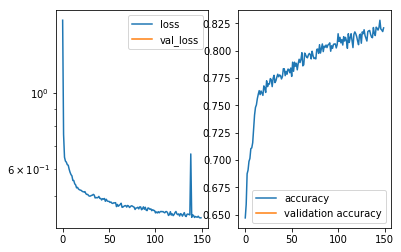

In [7]:
model = KerasClassifier(build_fn=create_model, callbacks=fit_callbacks, **best_params)
model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, shuffle=True)

In [8]:
model = create_model()
model.load_weights(filepath)

### Define Analysis Functions

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Evaluate on Test Data

In [10]:
y_prob = model.predict(X_test)
y_pred = np.round(y_prob)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cohen = cohen_kappa_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)
print("Cohen's Kappa:", cohen)

Accuracy: 0.7833553500660502
Precision: 0.8612975391498882
Recall: 0.7905544147843943
F1: 0.8244111349036403
Cohen's Kappa: 0.5430022822645955


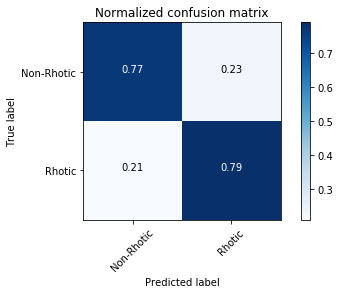

In [11]:
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])
plot_confusion_matrix(cnf_matrix, classes=['Non-Rhotic', 'Rhotic'], normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('results/confusion_matrix.png', bbox_inches='tight')

ROC AUC Score: 0.8687580804623927


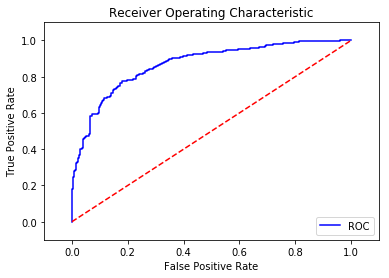

<Figure size 432x288 with 0 Axes>

In [12]:
# y_prob = model.predict_proba(X_test)#[:,1]
false_pos, true_pos, threshold = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC AUC Score:", roc_auc)

plt.title('Receiver Operating Characteristic')
plt.plot(false_pos, true_pos, 'b', label='ROC')
plt.plot([0, 1], [0, 1],'r--')
plt.legend(loc = 'lower right')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.savefig('results/roc.png', bbox_inches='tight')